In [ ]:
# Importing packages
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
from statsmodels.tsa.stattools import adfuller
import warnings
# Suppress all warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import zscore

# Loading data
df = pd.read_csv('initial_data2.csv')

# Converting Date column to Datetime object
df['Date'] = pd.to_datetime(df['Date'])

## Abstract

This project aimed to predict COVID vaccine rates, utilizing various time series forecasting models such as ARIMA, Auto_ARIMA, Prophet (both univariate and multivariate), XGBoost, and an LSTM model. The methodologies involved extensive data preparation, model training, and evaluation, with careful consideration of each model's parameters. The key findings underscored the superior performance of the ARIMA model, particularly noteworthy for its ability to capture subtle trends in the data and its independence from external variables. The collaborative learning process played a pivotal role in this project, fostering an environment where group members collectively navigated challenges, exchanged insights, and collectively enhanced their data science skills. The shared learning experience not only propelled individual understanding and proficiency but also provided motivation and support throughout the project. Ultimately, the collaborative effort and exploration of diverse models and methodologies contributed to a comprehensive understanding of COVID vaccine rate prediction, with the ARIMA model emerging as the most effective in this context.

# Project and Data Overview

## Project Overview

Utilizing a CDC database that compiles weekly-reported vaccine equity data at the state level in the United States, my objective is to forecast the percentage of individuals nationwide who have completed both the primary series of vaccination and received a booster dose. This dataset will undergo thorough cleaning and organization to facilitate time series prediction. Predictors for this endeavor encompass demographic information at the state level and specific data pertaining to vaccination rates among distinct age groups.

This undertaking holds significance as the current CDC mandate necessitates completion of the primary vaccine series and the booster. Consequently, the outcomes of this project aim to provide insights into the percentage of the U.S. population that satisfies this requirement.

The ultimate goal of the project is to contribute to forecasting future vaccination rates, thereby assisting governmental bodies, pharmaceutical companies, and the general public in making informed decisions.

## Data Overview and Preprocessing

I am utilizing data collected by the Centers for Disease Control and Prevention (CDC), which is accessible through the CDC’s Application Programming Interface (API). The original dataset comprises 109 variables and 39,000 values. It was aggregated daily per state from December 13, 2020, until May 10, 2023. The dataset primarily consists of numerical variables related to the number and percentages of vaccine distribution. In addition to cumulative figures, the variables break down the data by rates across various age groups, different vaccine manufacturers, and distinct stages of the vaccination process.

### Data Cleaning:
#### Imputing missing values and removing redundant features

In this project, my aim is to predict the percentage of the population receiving the initial booster. To achieve this, I addressed missing data, removed redundant columns, and investigated outliers. Features with over 1,000 missing values related to bivalent or second booster distribution were eliminated. To prevent data leakage, I ensured the absence of data on second booster doses, given their unavailability at the dataset's outset, introduced a year after the initial booster.

Columns measured both the proportion and count of vaccinated individuals in a state, essentially capturing the same metric at different scales. To streamline, I retained proportion columns, ensuring consistent scaling across states.

A substantial portion of data before November 2nd, 2021, was missing, aligning with the CDC’s recommendation for children aged five to eleven to receive the vaccine (Kates et al., 2021). For consistency, my dataset's starting point was adjusted to this date. Addressing missing entries on December 14th, 2022, I employed the Last Observation Carried Forward (LOCF) method (Abulkhair, 2023), using data from December 7th, 2022, to fill gaps for states with incomplete information on December 14th, 2022.

### Temporal Aggregation:

The analysis also revealed that the there was a shift in June 2022, where the API transitioned from daily to weekly reporting. To maintain consistency, the dataset was resampled to capture weekly observations every Wednesday, aligning with the reporting pattern post-June 2022.

### Outlier Detection:

For outlier detection, I employed the average for each feature across observations, with the date serving as the index. Opting for segmented analysis, I divided the dataset into monthly segments, calculating the IQR for each. This approach allows us to discern if outliers are specific to certain months due to significant variations in vaccination rates month-to-month. Through this technique, no outliers were identified the dataset. Although the plot has one red dot, I believ it is due to small change in the trend that can be seen at that point in time. Based on visualizations the red was dismissed as a significant outlier.

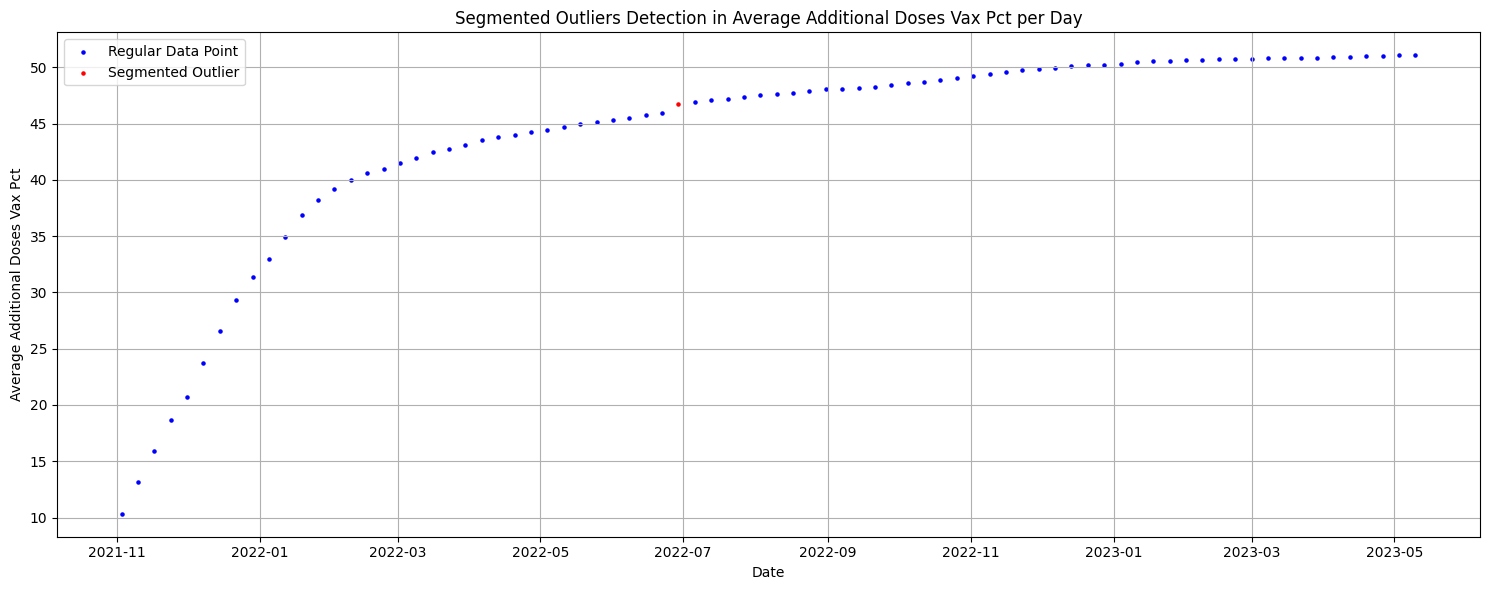

In [ ]:
#### Data Preparation and Cleaning

# find na value counts
missing_counts = df.isna().sum()

# Sort the missing value counts in descending order
missing_counts_sorted = missing_counts.sort_values(ascending=False)

# columns with over 1000 missing values
columns_with_over_1000_missing = missing_counts_sorted[missing_counts_sorted > 1000].index

# remove columns with over 1000 missing
df = df.drop(columns=columns_with_over_1000_missing)

# list of numerical columns wihh equivalent percentage columns to drop
columns_to_drop = [
       'Administered_Dose1_Recip',
       'Administered_Dose1_Recip_5Plus',
       'Administered_Dose1_Recip_12Plus',
       'Administered_Dose1_Recip_18Plus',
       'Administered_Dose1_Recip_65Plus',
        'Series_Complete_Yes',
        'Series_Complete_5Plus',
        'Series_Complete_12Plus',
        'Series_Complete_18Plus',
       'Series_Complete_65Plus',
       'Additional_Doses_18Plus',
       'Additional_Doses_50Plus',
       'Additional_Doses_65Plus']

# Dropping the columns from the df
df = df.drop(columns = columns_to_drop)

# Defining response variable for easier
pred_var = 'Additional_Doses_Vax_Pct'

given_date = pd.to_datetime('2021-11-02')

df = df[df['Date'] > given_date]

specific_day = '2022-12-14'

specific_day_data = df.loc[df['Date'] == specific_day]

rows_with_missing_values = specific_day_data[specific_day_data.isnull().any(axis=1)]


location_values = rows_with_missing_values['Location'].tolist()

# Month column
df['month'] = df['Date'].dt.month

# Year column
df['year'] = df['Date'].dt.year

# Filter the DataFrame for dates in December 2022
december_2022_data = df[(df['year'] == 2022) & (df['month'] == 12)]

for location in location_values:
    # Subset data for the specific location
    location_data = df[df['Location'] == location]

    # Subset data for the specific dates
    dates_to_impute = location_data[location_data['Date'].isin(['2022-12-07', '2022-12-14'])]

    # Perform forward fill (LOCF) imputation for the specific location and dates
    imputed_data = dates_to_impute.bfill()

    # Update the original DataFrame with the imputed data for the current location
    df.loc[imputed_data.index, imputed_data.columns] = imputed_data

    june_2022_data = df[(df['year'] == 2022) & (df['month'] == 6)]

dec_2021_data = df[(df['year'] == 2021) & (df['month'] == 12)]

df['day_of_week'] = df['Date'].dt.day_name()

# Identifying day of week
given_date = pd.to_datetime('2022-06-22')
days = df[df['Date'] > given_date]

df = df[df['day_of_week'] == 'Wednesday']

# outlier detection

avg_vax_pct_per_day = df.groupby('Date')['Additional_Doses_Vax_Pct'].mean().reset_index()
# Convert 'Date' to datetime format
avg_vax_pct_per_day['Date'] = pd.to_datetime(avg_vax_pct_per_day['Date'])

# Create a month-year column for segmentation
avg_vax_pct_per_day['Month_Year'] = avg_vax_pct_per_day['Date'].dt.to_period('M')

# Group by Month_Year and calculate IQR for each month
iqr_values = avg_vax_pct_per_day.groupby('Month_Year')['Additional_Doses_Vax_Pct'].apply(lambda x: (x.quantile(0.25), x.quantile(0.75))).reset_index()
iqr_values.columns = ['Month_Year', 'IQR_Values']
iqr_values['Q1'] = iqr_values['IQR_Values'].apply(lambda x: x[0])
iqr_values['Q3'] = iqr_values['IQR_Values'].apply(lambda x: x[1])
iqr_values['Lower_Bound'] = iqr_values['Q1'] - 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])
iqr_values['Upper_Bound'] = iqr_values['Q3'] + 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])

# Merge the IQR values back to the main dataframe
avg_vax_pct_per_day = pd.merge(avg_vax_pct_per_day, iqr_values, on='Month_Year')

# Determine if a data point is an outlier for its respective month
avg_vax_pct_per_day['is_segmented_outlier'] = (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] < avg_vax_pct_per_day['Lower_Bound']) | (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] > avg_vax_pct_per_day['Upper_Bound'])
# Scatter plot to see segmented analysis outliers
plt.figure(figsize=(15, 6))

# Plot non-outliers in blue and outliers in red
plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Date'],
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Additional_Doses_Vax_Pct'],
            color='blue', s=5, label='Regular Data Point')

plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Date'],
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Additional_Doses_Vax_Pct'],
            color='red', s=5, label='Segmented Outlier')

plt.title('Segmented Outliers Detection in Average Additional Doses Vax Pct per Day')
plt.xlabel('Date')
plt.ylabel('Average Additional Doses Vax Pct')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Feature Engineering:

In my time-series analysis, I recognized the importance of feature engineering to uncover potential predictors not explicitly present in the CDC’s API. As a result, I integrated columns indicating the quarter, month, year, day of the week, day of the month, day of the year, and week of the year for each observation. Additionally, I established columns denoting the season of the observation (Winter, Spring, Fall, or Summer). To enhance the analysis, I incorporated a Boolean column indicating if the week of the observation encompassed a holiday, using the holidays Python library, and another to denote if it contained a vaccine announcement by the CDC (Montel, 2017; Hahn, n.d.).

In [ ]:
# Quarter column
df['quarter'] = df['Date'].dt.quarter

# Day of year column
df['dayofyear'] = df['Date'].dt.dayofyear

# Day of month column
df['dayofmonth'] = df['Date'].dt.day

# Week of year column
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(np.int64)

# Defining function to identify season
def get_season(date):
    month = date.month
    day = date.day
    if month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    elif month in [9, 10, 11]:
        season = 'fall'
    else:
        season = 'winter'


    if month == 3 and day < 20:
        season = 'winter'
    elif month == 6 and day < 21:
        season = 'spring'
    elif month == 9 and day < 22:
        season = 'summer'
    elif month == 12 and day < 21:
        season = 'fall'

    return season

# Applying function and creating season column
df['season'] = df['Date'].apply(get_season)

# Create a list of US holidays for the given year range in the dataframe
us_holidays = holidays.US(years=[df['Date'].dt.year.min(), df['Date'].dt.year.max()]).keys()

# Convert us_holidays to a pandas Series of datetime objects
us_holidays_series = pd.Series(pd.to_datetime(list(us_holidays)))

# Create Holiday column
df['holidays'] = df['Date'].isin(us_holidays_series) | (df['Date'] + pd.Timedelta(days=1)).isin(us_holidays_series)
df['holidays'] = df['holidays'].replace({True: 'Holiday', False: 'Normal day'})

# Determine which weeks have a holiday
holiday_weeks = us_holidays_series.dt.strftime('%U-%Y').unique()

# Assign a "holiday season" for every date that's within a week having a holiday
df['holiday_season'] = df['Date'].dt.strftime('%U-%Y').isin(holiday_weeks)

# Define a list of unique announcement dates
announcement_dates = [
    "04/28/2023", "04/27/2023", "04/18/2023", "03/14/2023", "03/10/2023",
    "12/16/2022", "12/08/2022", "10/21/2022", "10/12/2022", "09/13/2022",
    "08/31/2022", "08/26/2022", "08/19/2022", "07/13/2022", "07/08/2022",
    "06/30/2022", "06/17/2022", "05/17/2022", "05/05/2022", "04/29/2022",
    "04/15/2022", "04/01/2022", "03/29/2022", "03/21/2022", "03/11/2022",
    "02/11/2022", "02/01/2022", "01/31/2022", "01/11/2022", "01/07/2022",
    "01/03/2022", "12/17/2021", "12/14/2021", "12/09/2021", "11/30/2021",
    "11/19/2021", "10/29/2021", "10/26/2021", "10/22/2021", "10/20/2021",
    "10/14/2021", "10/01/2021", "09/24/2021", "09/22/2021", "09/20/2021",
    "09/17/2021", "09/10/2021", "09/02/2021", "09/01/2021", "08/24/2021",
    "08/23/2021", "08/18/2021", "08/13/2021", "08/12/2021", "08/06/2021",
    "08/03/2021", "07/30/2021", "07/16/2021", "07/13/2021", "07/08/2021",
    "07/06/2021", "07/02/2021", "06/29/2021", "06/25/2021", "06/15/2021",
    "06/11/2021", "06/10/2021", "05/25/2021", "05/19/2021", "05/11/2021",
    "05/10/2021", "04/27/2021", "04/23/2021", "04/21/2021", "04/16/2021",
    "04/13/2021", "04/12/2021", "04/01/2021", "03/26/2021", "03/24/2021",
    "03/17/2021", "03/05/2021", "03/02/2021", "02/27/2021", "02/26/2021",
    "02/25/2021", "02/23/2021", "02/22/2021", "02/12/2021", "02/05/2021",
    "02/04/2021", "01/29/2021", "01/14/2021", "01/04/2021", "12/28/2020",
    "12/22/2020", "12/21/2020", "12/18/2020", "12/17/2020", "12/14/2020", "12/12/2020"
]

# Convert to datetime and deduplicate
announcement_dates = list(set([pd.to_datetime(date) for date in announcement_dates]))

# Convert announcement dates to week-year format
announcement_weeks = [date.strftime('%U-%Y') for date in announcement_dates]

# Check if the date in the dataset is within the same week of any announcement dates
def in_announcement_week(date):
    return date.strftime('%U-%Y') in announcement_weeks

# Create the 'vax_announcement' column
df['vax_announcement'] = df['Date'].apply(in_announcement_week)

# Exploratory Data Analysis

### Temporal Visualizations & Seasonal Decomposition:

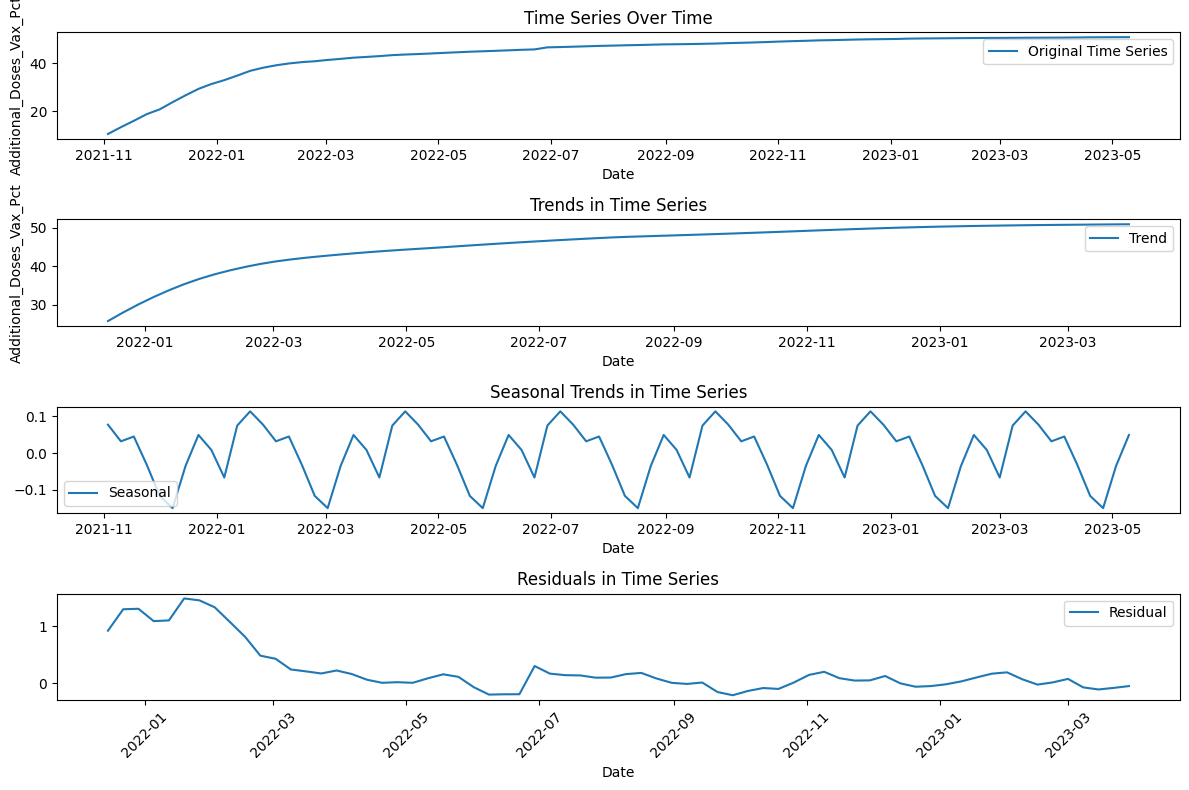

In [ ]:
# group data by date as there are multiple entires per each date
time_series_data = df.groupby('Date')[pred_var].mean().reset_index()
# set index to date
time_series_data = time_series_data.set_index('Date')
# STL decomposition to investigating trends, seasons and residual

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Perform STL decomposition with a known seasonality period (e.g., 12 for monthly data)
result = sm.tsa.seasonal_decompose(time_series_data[pred_var], model='stl', period=12)

# Access the decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

# Plot a subset of data (e.g., every 30th data point)
plt.subplot(4, 1, 1)
plt.plot(time_series_data[pred_var], label='Original Time Series')
plt.legend()
plt.title('Time Series Over Time')
plt.xlabel('Date')
plt.ylabel(pred_var)


plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
plt.title('Trends in Time Series')
plt.xlabel('Date')
plt.ylabel(pred_var)



plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Trends in Time Series')
plt.xlabel('Date')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()
plt.title('Residuals in Time Series')
plt.xlabel('Date')

# Customize x-axis labels to rotate by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


We have used the STL decomposition to investigate potential trends, seasons and residuals. Based on the STL plot, we have learned that `Additional Doses Vax Pct` has a very steep increase in the first 4-5 months after its initial release and then the rate has tapered and increased at a small and steady rate. This was expected as most people who wanted the booster, receved it when it first came out. The seasonal plot provides clear evidence for a seasonal pattern. This pattern is something we kept in mind and explored further in variable analysis. We will have to account for this pattern in a variety of ways moving forward with the project. For example one of the solutions is to use an ARIMA model which can account for seasonal components. However, for other models we have creaed a categorical `Season` variable. Lastly, the Residual pattern suggests that teh STL may not have adequately captured some underlying patterns or structures in our time series data.

### Correlation Analysis:

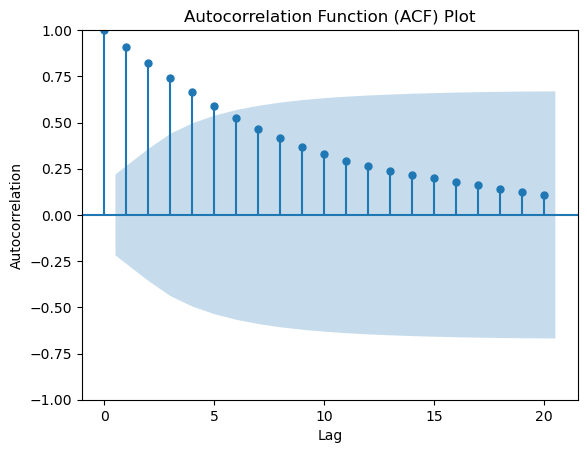

In [ ]:
# ACF plot

# Create the ACF plot
plot_acf(time_series_data[pred_var])

# Customize the plot (optional)
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Show the plot
plt.show()

This ACF pattern is commonly observed in time series data with a strong short-term memory or persistence. It implies that the most recent values have a more pronounced impact on the current value, and the impact of earlier values diminishes gradually. The decay in autocorrelation suggests a relatively fast decrease in correlation with increasing time lags. Autoregressive models are ideal for dealing with this particular autocorrelation pattern.
To investigate this further we have looked at the PACF graph and identified the biggest spike at value of 1. Autoregressive models are  To deal with this particular autocorrelation pattern  To prevent correlation issues in our model we added a new lag variable with the shift of 1 week to our dataset.

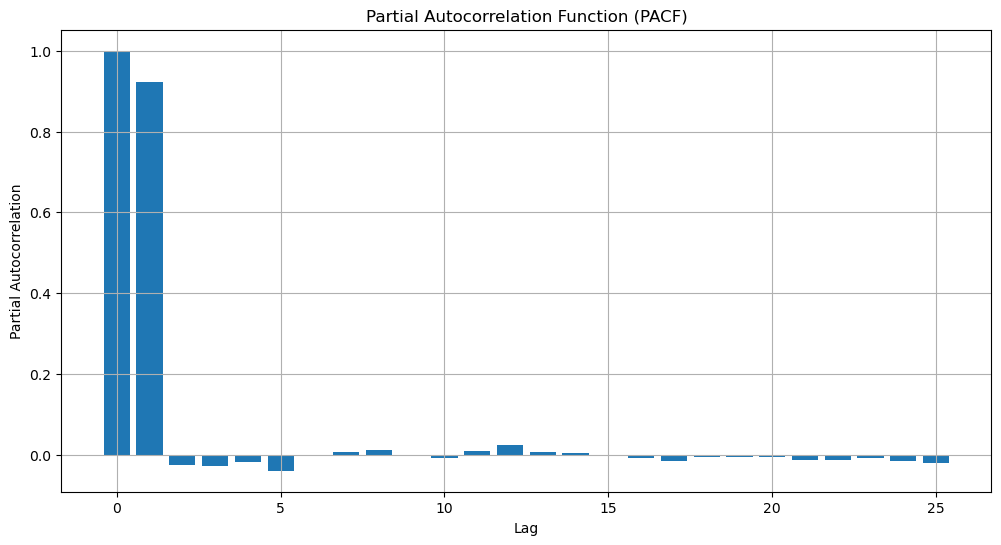

In [ ]:
# PACF Plot

# Calculate the PACF
pacf = sm.tsa.pacf(time_series_data, nlags=25)

# Create the PACF plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(pacf)), pacf)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

In [ ]:
df['Additional_Doses_Vax_Pct_1_w_lag'] = df['Additional_Doses_Vax_Pct'].shift(1)

In [ ]:
features_target = df[['day_of_week',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
                      'season', 'holidays', 'holiday_season', 'vax_announcement',
       'Additional_Doses_Vax_Pct_1_w_lag', pred_var,'Date']]
features_target = features_target.set_index('Date')

### Univariate Analysis:
#### Distribution of Response Variable
Here, we can see that the response variable is skewed to the leftand that the most significant concentration of data lies between the 30% to 50% vaccination rate, suggesting that for many samples, the percentage of additional doses administered falls within this range. It's worth noting the scarcity of data points both below 10% and above 60%. This indicates that very low and very high vaccination rates are less common among the samples we have.

<Axes: xlabel='Additional_Doses_Vax_Pct', ylabel='Count'>

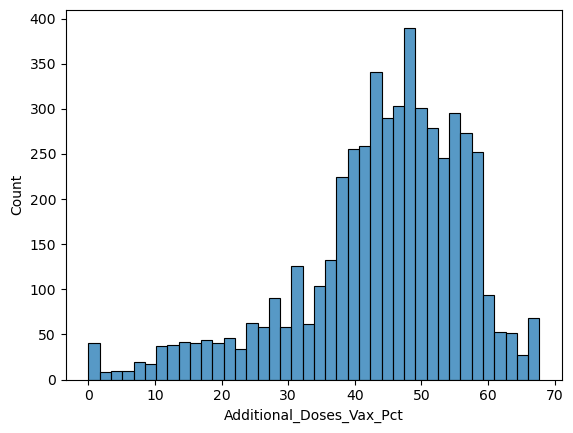

In [ ]:
# Distribution of response variable
sns.histplot(df[pred_var], kde=False )

#### Distribution of features after data cleaning and imputation

We can see that many of the features are relatively normally distributted with some having an extreme skew. As we develop the models, we may apply log transformations to those with extreme skews if we feel it is necessary.

In [ ]:
# Distribution of features after data cleaning and imputation

# find continous/ numerical variables
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# plot d
%matplotlib inline
df.hist (column= continuous_vars,figsize= (50,30))
#hides array names that are otherwise printed
_ = plt.plot()

#### Distribution of feature-engineered `season`

We can see that there are more observations from the winter. This may have been because of where we start and end out data as a result of vaccine guidelines for 5-11 year olds.

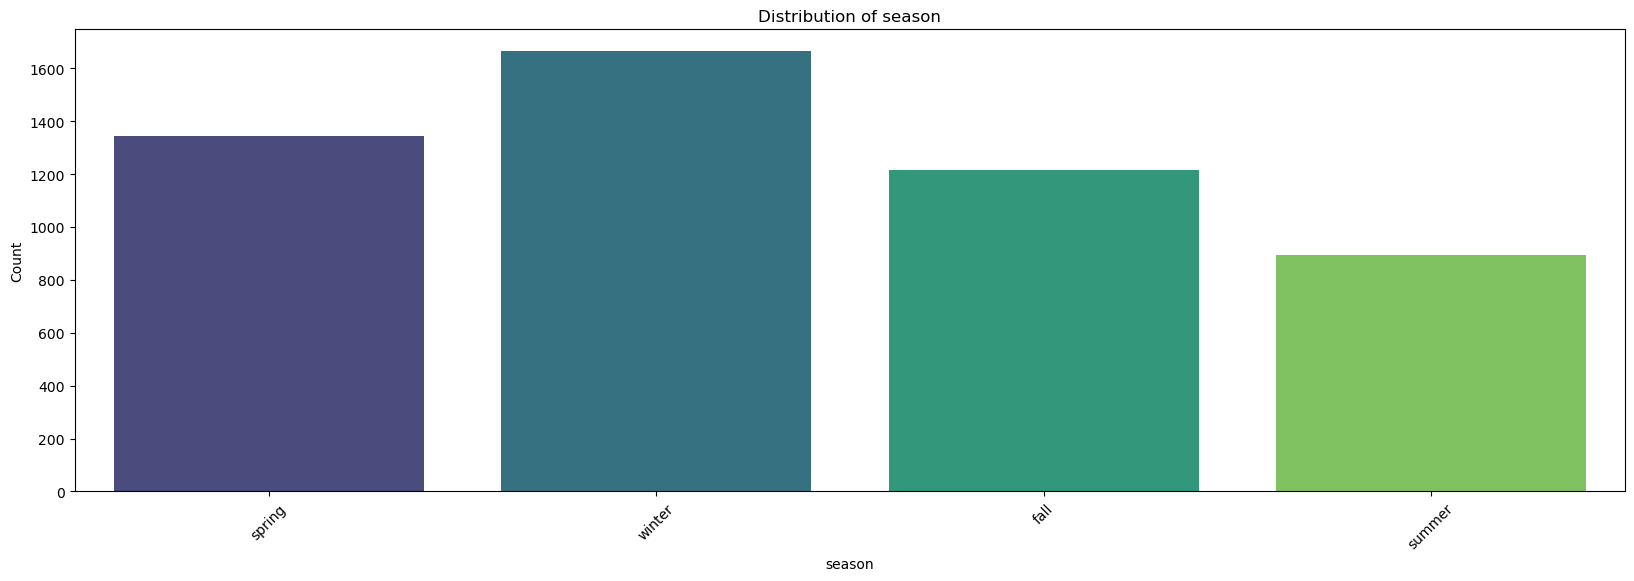

In [ ]:
# Distribution of season
categorical_variable = 'season'

# Create a countplot
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x=categorical_variable, palette='viridis')
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Distribution of feature-engineered `holiday_season`

We can observe that relatively few vaccination rates were reported in weeks when there was a US holiday. It will be interesting to see if this features affects the models greatly.

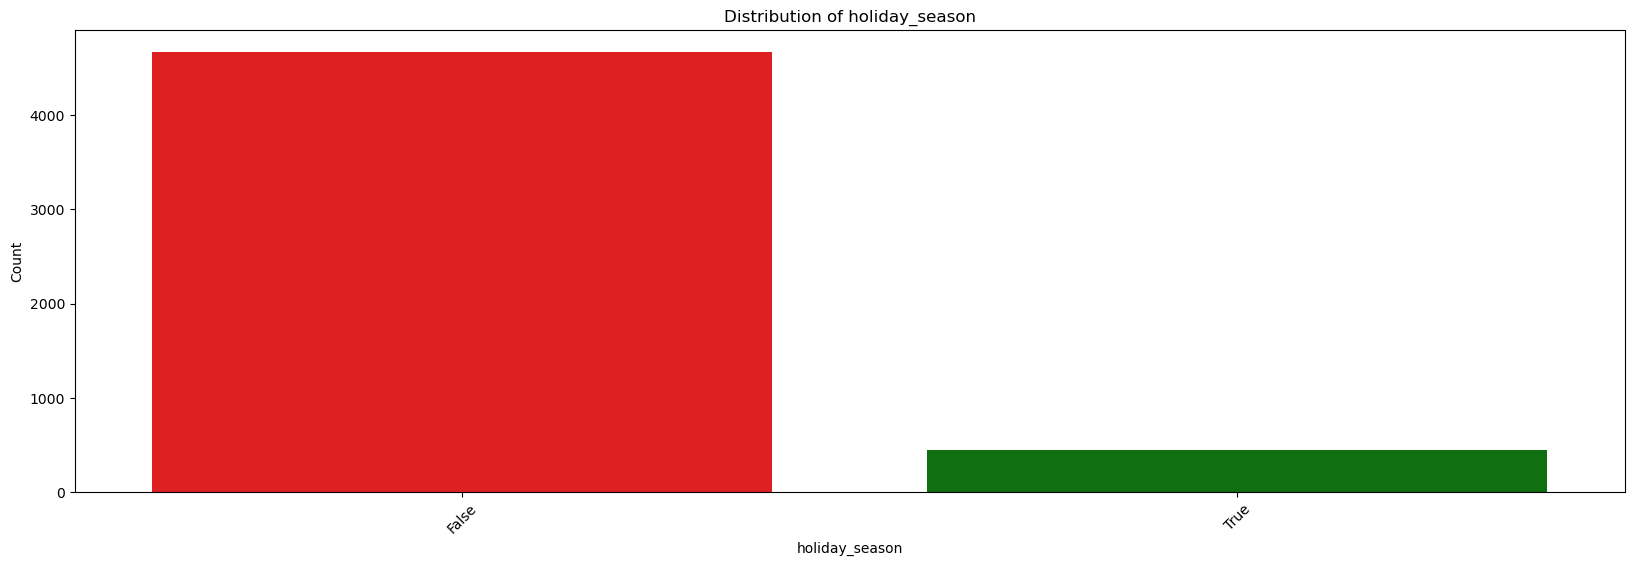

In [ ]:
# Custom Boolean color palette
boolean_palette = {True: 'green', False: 'red'}

# Distribution of holidays
categorical_variable = 'holiday_season'

# Create a countplot
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x=categorical_variable, palette=boolean_palette)
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Distribution of feature-engineered `vax_announcement`

There are a pretty significant proportiion of vaccine rate observations on a week where there was a CDC vaccine announcement. This could be because there were a lot of announcements reported, though.

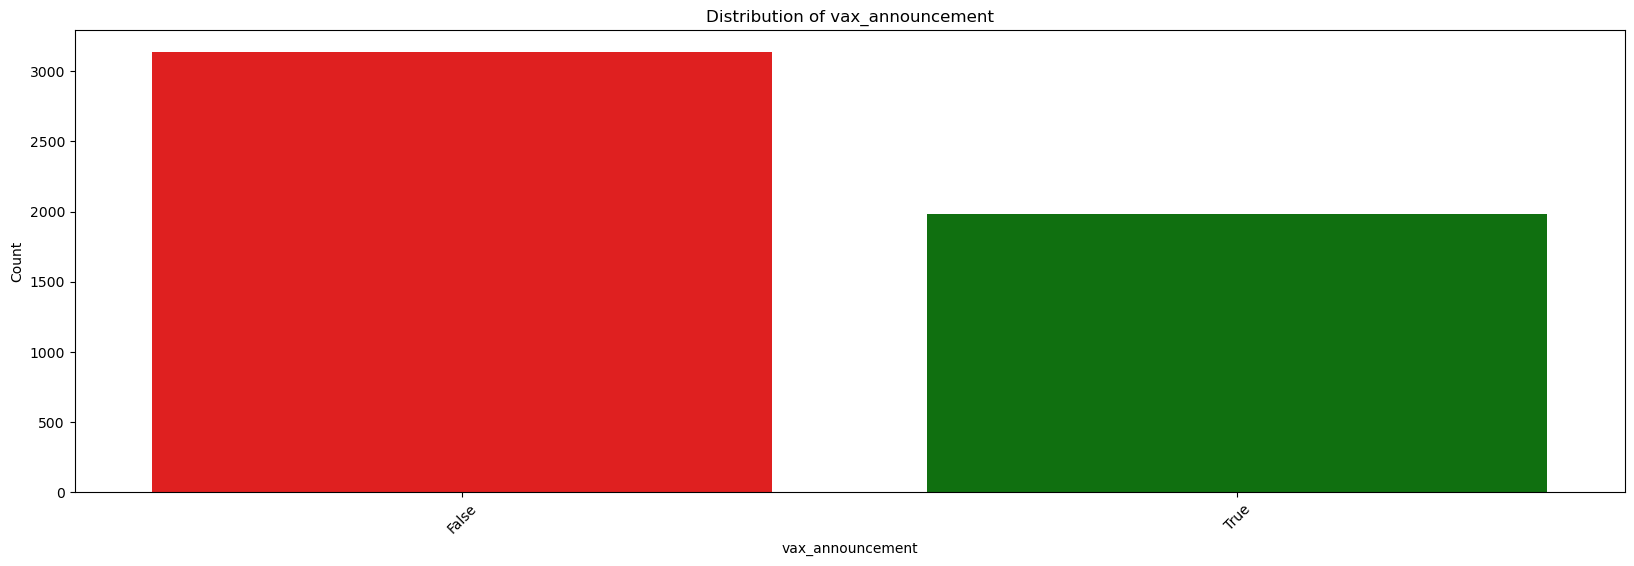

In [ ]:
# Distribution of doses near vaccine announcements
categorical_variable = 'vax_announcement'

# Create a countplot
plt.figure(figsize=(20, 6))  # Set the figure size
sns.countplot(data=df, x=categorical_variable, palette=boolean_palette)
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Distribution of `Location`
The observations across locations are almost completely even with around 15 less reports from Palau and around 60 less reports from the location code RP (we were unable to find this location's corresponding state/territory name). We will monitor whether this will affect model development or accuracy.

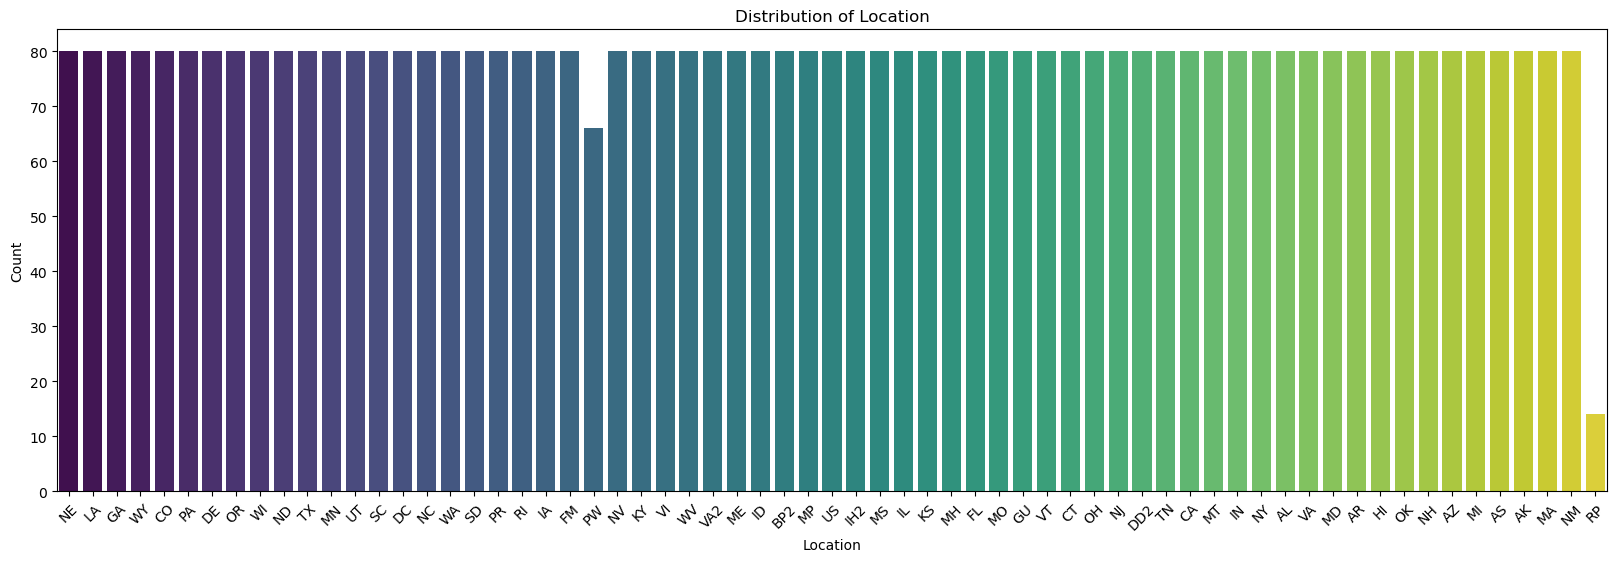

In [ ]:
# Distribution of Location
categorical_variable = 'Location'

# Create a countplot
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x=categorical_variable, palette='viridis')
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Bivariate Analysis:

To further investigate the seasonal trends found in the STL decomposition plots we have plotted box plots of `Month` and `Season` against our prediction variable. Based on these plots we can see that the median across all categories is pretty similar. However, both November and Fall have a significanly larger IQR. This is potentially related to the fact that our data subset starts in Novemember (Fall), meaning that it had a lot of low % values in 2021 when the COVID booster first came out.

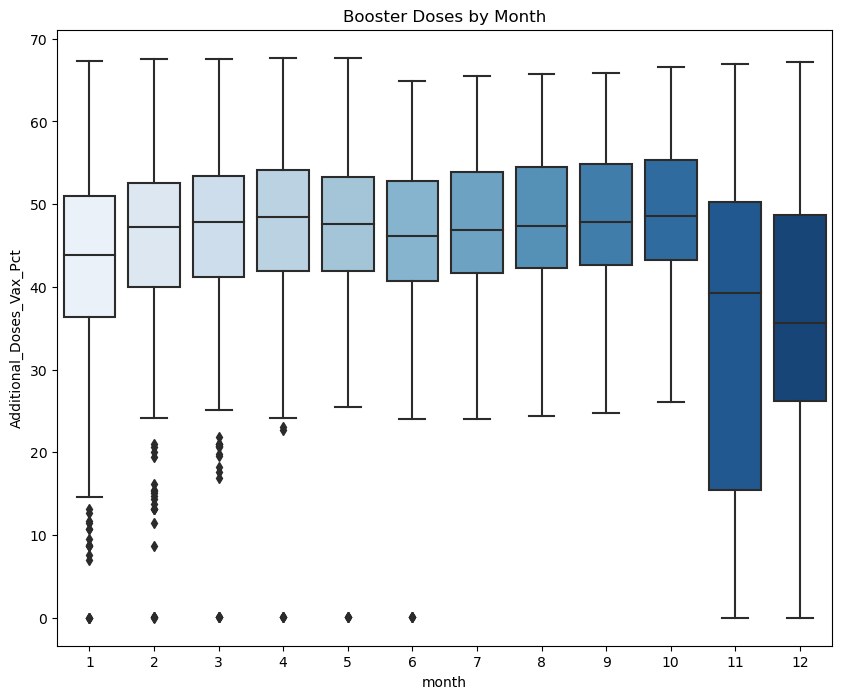

In [ ]:
# visualize the monthly pred_var
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=features_target, x='month', y=pred_var, palette='Blues')
ax.set_title('Booster Doses by Month')
plt.show()

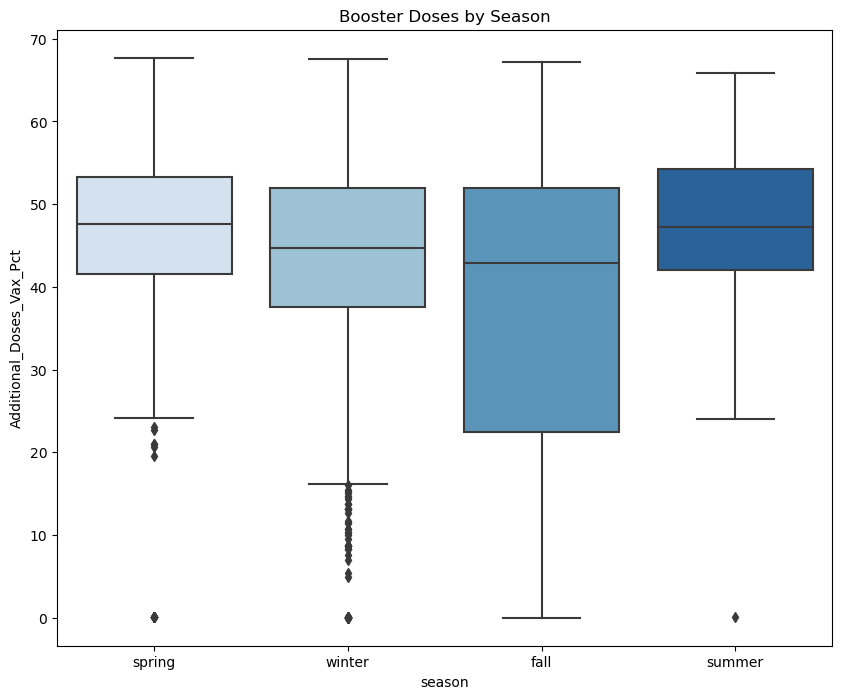

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=features_target, x='season', y=pred_var, palette='Blues')
ax.set_title('Booster Doses by Season')
plt.show()

### Multivariate Analysis:

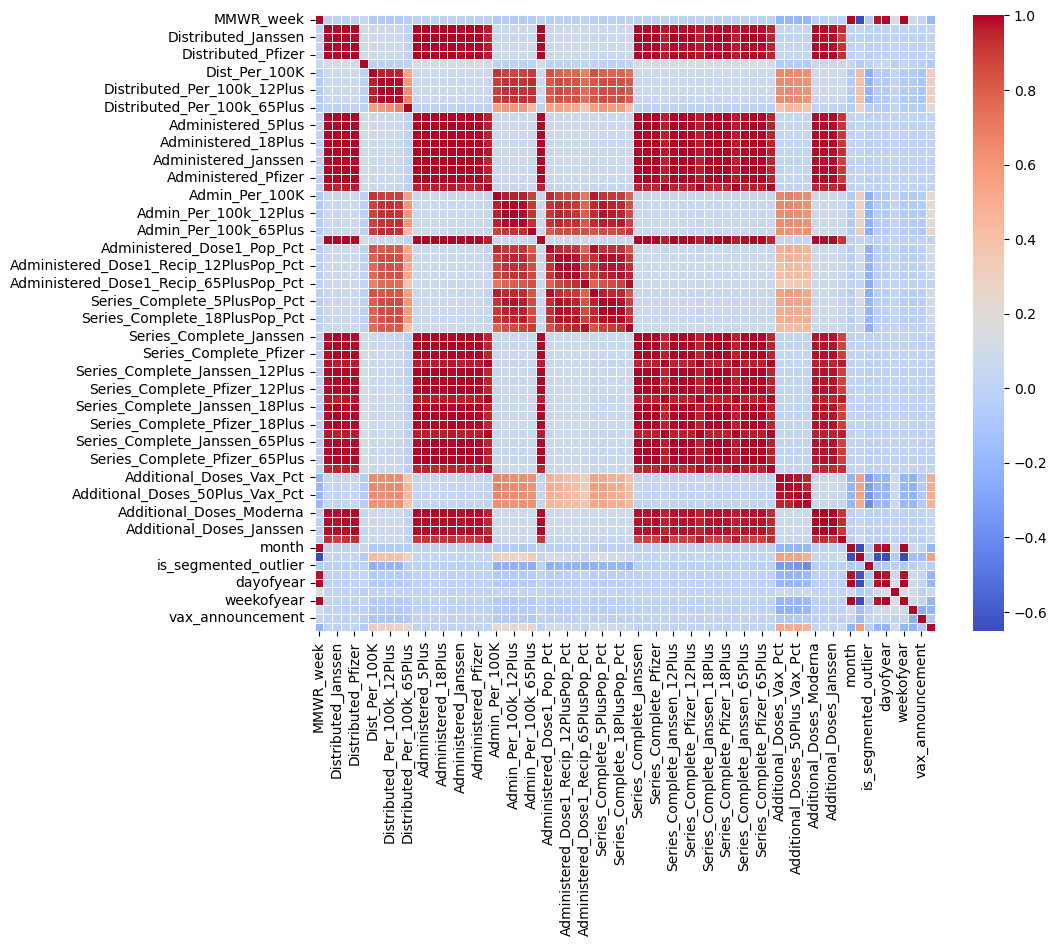

In [ ]:
# heat map to show correlation between variables

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)

plt.show()

<Axes: >

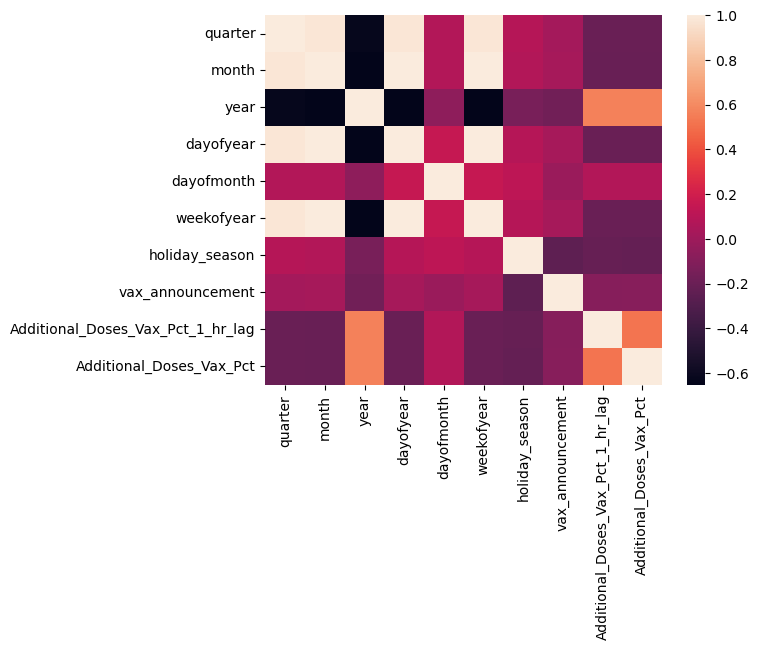

In [ ]:
correlation = features_target.corr( method='pearson' )
sns.heatmap( correlation )

Based on multivariate heatmaps there are few variables that have relatively high correlation with our prediction variable. These features will have to be investigated further when we are working on variable selection for our prediction models.

# Methodology


## ARIMA Model


In [ ]:
## Data Preparation

pred_var = 'Additional_Doses_Vax_Pct'

df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()

#subset data to be only dates and predicting variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data_w = data.resample('W').sum()

from sklearn.preprocessing import MinMaxScaler
#scaling data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data_w), columns=data.columns, index=data_w.index)

### Data Preparation

In preparing the dataset for ARIMA, I narrowed down the variables to focus exclusively on the date and the target prediction variable, streamlining the analytical focus. The dataset was then grouped by 'Date,' with the date serving as a distinctive index. Despite the initial weekly format of the data, ARIMA presented challenges related to datetime intricacies and convergence warnings.

To address these concerns, I chose a weekly resampling approach, successfully rectifying errors linked to datetime disparities. Additionally, I introduced scaling to the dataset for uniformity in model comparisons, even though ARIMA traditionally doesn't necessitate scaling.

In evaluating the stationarity of the time series data, I made several key observations. Firstly, I identified a noticeable constant increasing trend in the prediction variable, suggesting non-stationarity. This is consistent with the theoretical definition of stationarity, where statistical properties such as the mean should remain constant over time—a condition inherently violated by a cumulative percentage prediction variable. To formally investigate stationarity, I opted for the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, seeking to test the null hypothesis that the data is stationary around a deterministic trend. The outcome of the KPSS test led to the rejection of the null hypothesis, reinforcing the non-stationary nature of the data. Subsequently, I delved into a detailed examination of the autocorrelation function (ACF) graph. The gradual decline in the trend observed in the ACF graph further supports the non-stationary characteristics of the data, as a stationary time series would typically exhibit a more rapid decay in autocorrelation. This thorough analysis, combining statistical testing and graphical exploration, provides a robust confirmation of the non-stationary nature of the prediction variable.

In [ ]:
# stationarity test
from statsmodels.tsa.stattools import kpss

result = kpss(data)
# Print the results
print(f'KPSS Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Interpret the results
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis).')
else:
    print('The time series is stationary (fail to reject the null hypothesis).')


KPSS Statistic: 1.0632874725225503
P-value: 0.01
The time series is non-stationary (reject the null hypothesis).


In addressing the prerequisite of stationarity for ARIMA modeling, I tried different orders of differentiation to transform the data appropriately. This process holds significance as ARIMA models assume stationary data for accurate forecasting. Upon inspecting the plots of the differentiated data, particularly after two orders of differencing, data appeared to be stationary. The resulting plot over time showcased a tendency of outliers, yet, on the whole, had a mean of 0. This observation aligns with the concept of stationarity, where the mean remains constant over time. To reinforce this, I scrutinized the autocorrelation function (ACF) plots for the different differentiations. The ACF plot for two orders of differencing exhibited a rapid drop-off, indicating a lack of significant autocorrelation beyond a few lags. This fast decay is indicative of stationary data, supporting the effectiveness of the double differentiation in achieving stationarity. In summary, the differentiation process, backed by visual inspection and ACF analysis, was pivotal in rendering the data stationary and, consequently, suitable for ARIMA modeling.

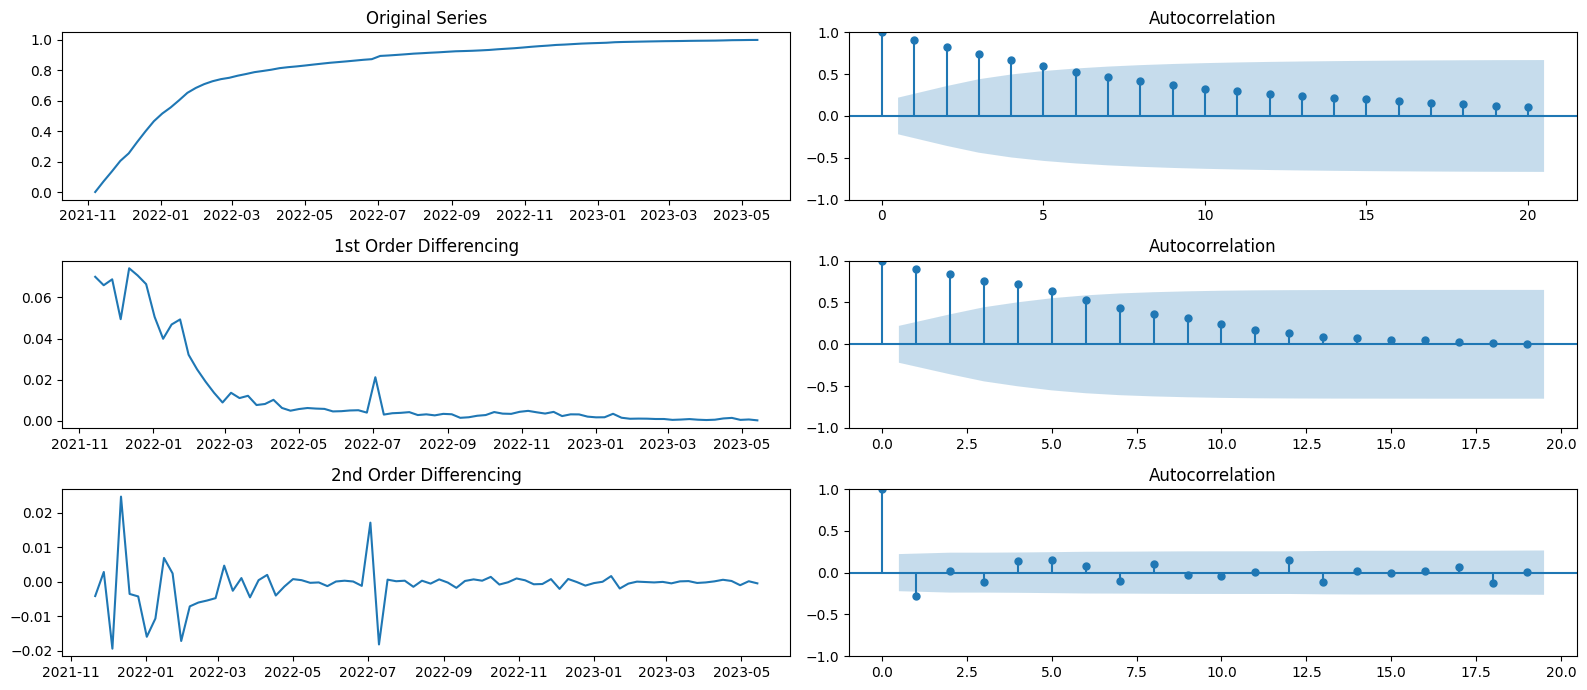

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(16, 7))

axes[0, 0].plot(data.index, data.values)
axes[0, 0].set_title('Original Series')
plot_acf(data, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.index, data.diff().values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.index, data.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

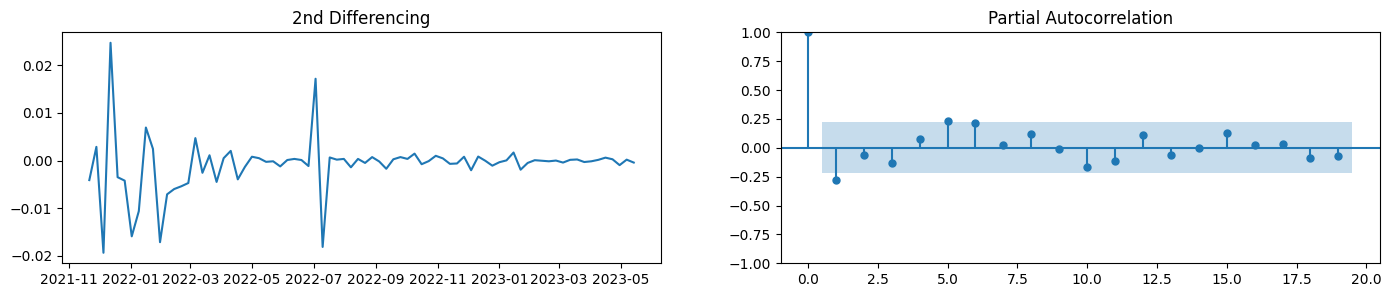

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams.update({'figure.figsize':(17,3)})

fig, axes = plt.subplots(1, 2)
axes[0].plot(data.index, data.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.diff().diff().dropna(), ax=axes[1])

plt.show()

In constructing the ARIMA model, I focused on three key parameters: p, d, and q, governing the autoregressive (AR), differencing (I), and moving average (MA) components, respectively.
My parameter choices were guided by a thorough analysis of the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. Initially, I observed that the data achieved stationarity after undergoing two orders of differencing (d=2), as revealed by the ACF plot. Additionally, none of the lags exceeded the significance limit, leading me to choose an initial value of q=0.
Further insights from the PACF plot indicated that, post two orders of differencing, only the first lag slightly exceeded the significance limit. Consequently, for the initial ARIMA model, I opted for p=1.
In essence, my parameter selection process involved a meticulous examination of ACF and PACF plots to ensure the model aptly captured the stationary characteristics of the differentiated data.

### Model Building

In formulating the model for my project, I opted for an 80/20 train and test split. A deliberate choice was made to forgo a random split, ensuring the preservation of chronological order based on the temporal variable, Date. This strategic sorting enables the training set to encompass historical observations, preventing any data leakage problems.
For assessing the model's performance, I chose the Root Mean Squared Error (RMSE) as the evaluation metric. RMSE is well-suited for time series prediction models as it accounts for the squared differences between predicted and actual values, emphasizing the significance of prediction accuracy. Importantly, RMSE penalizes larger errors more severely, aligning with the goal of minimizing prediction discrepancies. This metric's sensitivity to both magnitude and direction of errors makes it a valuable tool for gauging the overall accuracy of the model across the entire time series, providing a comprehensive measure of predictive performance.

I first fit an ARIMA model based on the p,d,q parameters established above (1,2,0).

In [ ]:
# Split data into test and train

split_date = int(len(data) * 0.8)
data = data.sort_index(ascending=True)

from statsmodels.tsa.arima.model import ARIMA
# Split the data
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]
# 1,1,2 ARIMA Model
base_model = ARIMA(train_data, order=(1,2,0)).fit()
print(base_model.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Additional_Doses_Vax_Pct   No. Observations:                   64
Model:                       ARIMA(1, 2, 0)   Log Likelihood                 226.255
Date:                      Sun, 26 Nov 2023   AIC                           -448.510
Time:                              20:47:55   BIC                           -444.256
Sample:                          11-07-2021   HQIC                          -446.840
                               - 01-22-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2511      0.073     -3.445      0.001      -0.394      -0.108
sigma2      3.955e-05   4.53e-06      8.727      0.000    3.07e-05    4.84e-05
Ljun

The model summary showed that AR1 term was significant( P>|z|) and had a non zero coefficient. This was good news as it meant that my initial parameter estimates were on the right track.

Train RMSE: 0.010722322765436578
Test RMSE: 0.010499051609189755


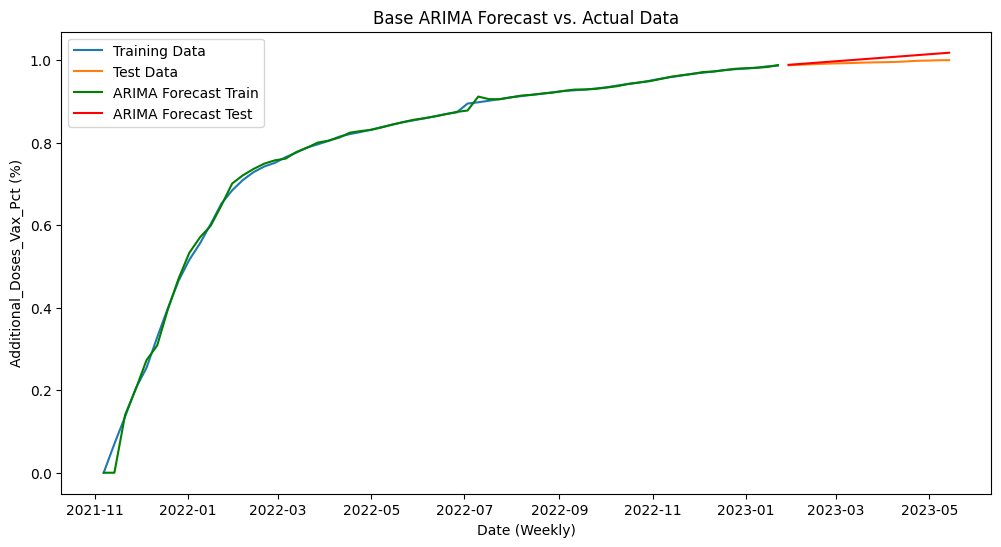

In [ ]:
# Forecast future values using the ARIMA model
n_forecast = len(test_data)
forecast = base_model.forecast(steps=n_forecast)
forcast_train = base_model.predict(start = train_data.index[0], end = train_data.index[-1], type = 'levels')


from sklearn.metrics import mean_squared_error
from math import sqrt
# Evaluate the model's performance
train_rmse = sqrt(mean_squared_error(train_data, forcast_train))
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {rmse}")


# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(train_data.index, forcast_train, label='ARIMA Forecast Train', color='green' )
plt.plot(test_data.index, forecast, label='ARIMA Forecast Test', color='red')
#plt.plot(data.index, forecast_whole, label='ARIMA', color='pink')
plt.legend()
plt.title('Base ARIMA Forecast vs. Actual Data')
plt.xlabel('Date (Weekly)')
plt.ylabel('Additional_Doses_Vax_Pct (%)')
plt.show()

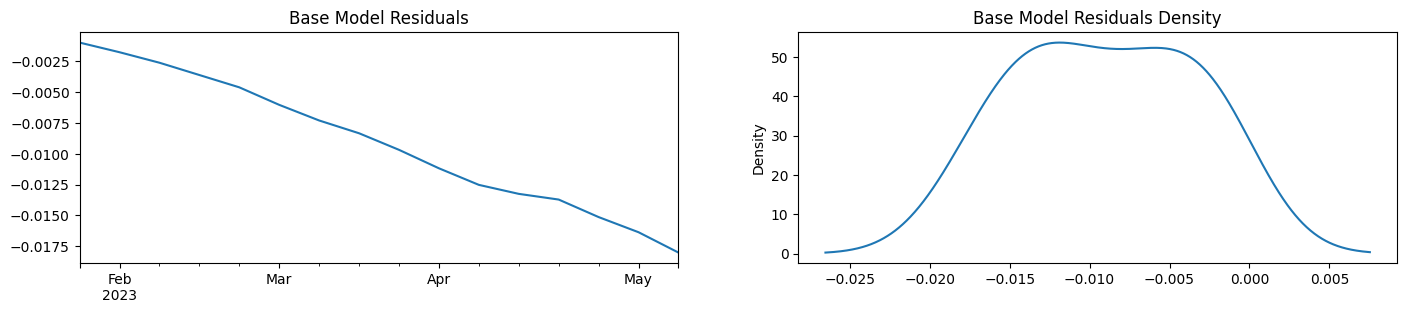

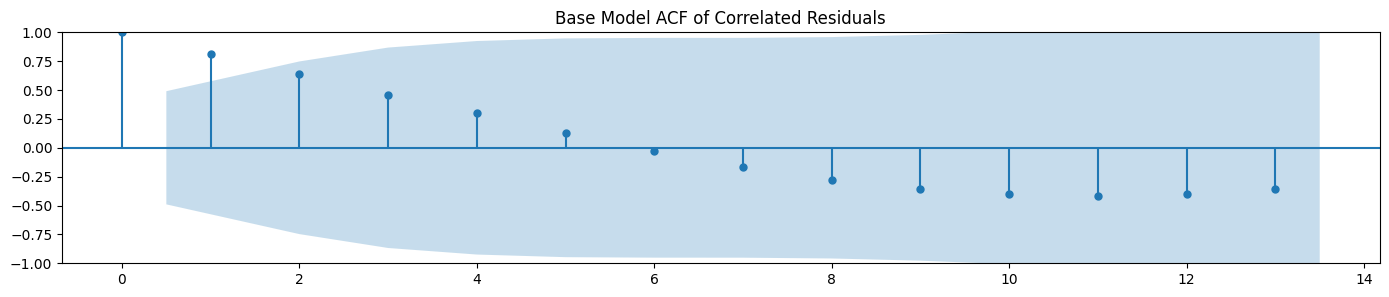

In [ ]:
# Plot residual errors
forecast_test_df = forecast.to_frame()
forecast_test_df['residuals']=test_data.values - forecast_test_df.values
residuals = forecast_test_df.residuals
fig, ax = plt.subplots(1,2)
residuals.plot(title="Base Model Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Base Model Residuals Density', ax=ax[1])
plt.show()

# Original Series
plt.figsize=(10, 8)
acf_original = plot_acf(residuals)
plt.title("Base Model ACF of Correlated Residuals")
plt.show()

Analysis of the plots indicates important findings. The negative slope in residuals suggests an unaddressed systematic trend in the ARIMA model, indicating potential needs for adjustments in differencing or trend components. The non-normal distribution in the density plot raises concerns about deviations from an ideal Gaussian distribution, implying the presence of unexplored patterns. The discernible pattern in the autocorrelation function (ACF) plot points to lingering correlations at specific lags, highlighting shortcomings in capturing temporal dependencies. Despite seemingly satisfactory RMSE performance, a detailed examination reveals substantial patterns unaddressed by the base ARIMA model. To enhance performance, I utilized Grid Search for hyperparameter tuning and employed a rolling one-step forecast technique for heightened adaptability in capturing underlying data patterns.

In [ ]:
# grid search

# grid search ARIMA parameters for time series
# backtesting time series
# evaluate an ARIMA model for a given order (p,d,q)
# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.8)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					#print('ARIMA%s RMSE=%.8f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.8f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1,2,3,4]
d_values = range(1, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(data.values, p_values, d_values, q_values)

Best ARIMA(1, 1, 0) RMSE=0.00035116


Test RMSE: 0.00035114857779660583


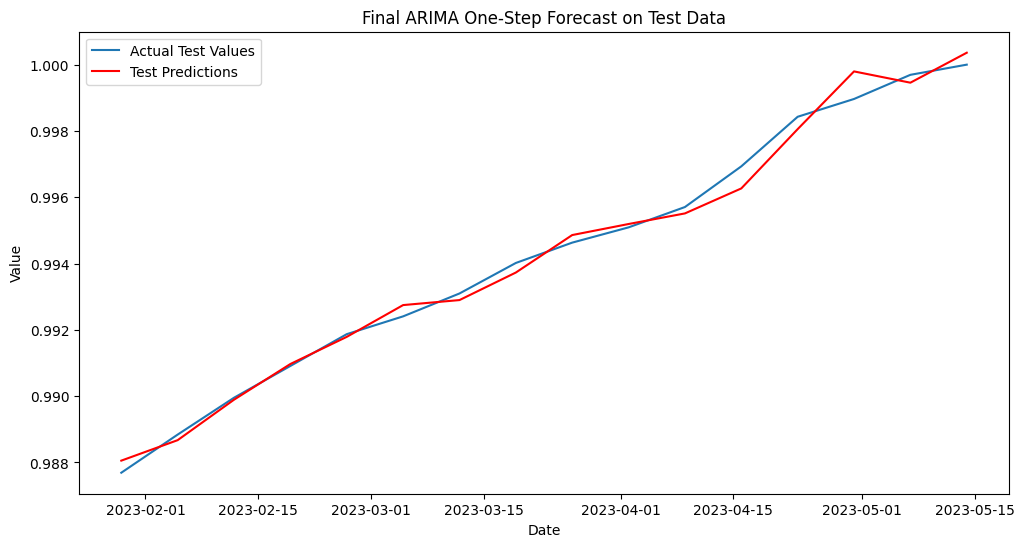

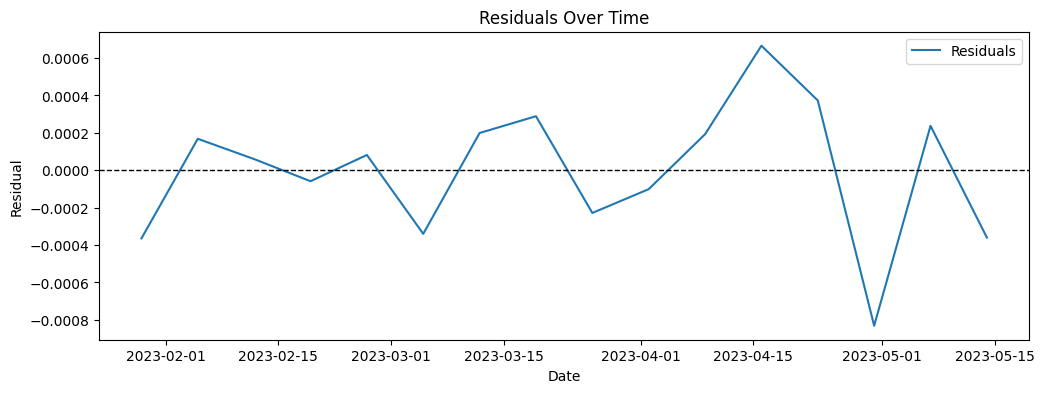

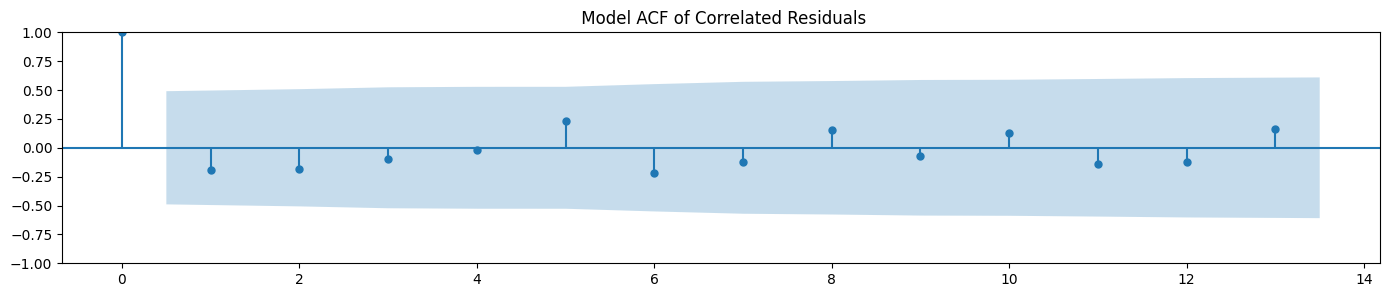

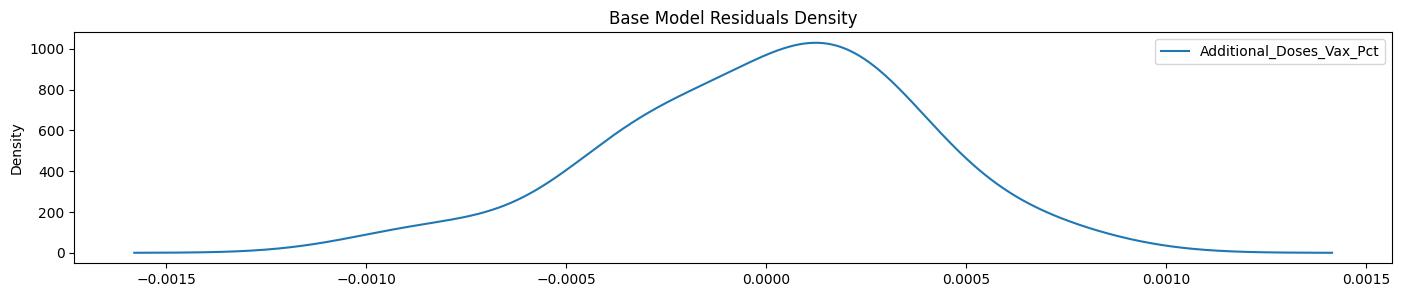

In [ ]:
### Final ARIMA Model

# Fit ARIMA model on the training data
model = ARIMA(train_data, order=(1, 1, 0))
model_fit = model.fit()
train_size = len(train_data.values)
# Initialize empty lists to store predictions and residuals
predictions = []
residuals = []

# Perform rolling one-step forecast on the test data
for i in range(len(test_data)):
    # Fit the model on the available training data
    model = ARIMA(data[:train_size + i], order=(1, 1, 0))
    model_fit = model.fit()

    # Make a one-step forecast
    yhat = model_fit.forecast(steps=1)[0]

    # Append the prediction to the list
    predictions.append(yhat)

    # Append the residual to the list
    residuals.append(test_data.iloc[i] - yhat)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(test_data, predictions))
print(f"Test RMSE: {rmse}")

# Plot the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Test Values')
plt.plot(test_data.index, predictions, label='Test Predictions', color='red')
plt.title('Final ARIMA One-Step Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the residuals over time
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, residuals, label='Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

residuals = pd.DataFrame(residuals)
# Residuals ACF
plt.figsize=(10, 8)
acf_original = plot_acf(residuals)
plt.title(" Model ACF of Correlated Residuals")
plt.show()

# Residual Density
residuals.plot(kind='kde', title='Base Model Residuals Density')
plt.show()

To optimize my rolling one-step forecast ARIMA model, I conducted a grid search, systematically exploring various parameter combinations for autoregressive order (p), differencing order (d), and moving average order (q). The optimal parameters identified were p=1, d=1, q=0, showcasing significantly improved predictive performance with a remarkably low test root mean square error (RMSE). The systematic and exhaustive nature of the grid search facilitated the identification of the most effective parameter configuration for accurate predictions.
In my analysis using a rolling one-step forecast ARIMA model, residuals exhibited a relatively uniform distribution, with the mean fluctuating around zero. Predictions closely matched actual values, aligning with expectations for a rolling one-step forecast. This approach's adaptability, continuously updating the model with the latest data, likely contributed to its ability to closely track evolving patterns in the time series. The observed improvements in the rolling one-step forecast model, compared to the standard ARIMA model, make sense given its superior performance in capturing changing dynamics and incorporating recent information.

## Auto_ARIMA


### Data Preparation

Auto-ARIMA is an extension of the ARIMA model that automates the selection of key hyperparameters, including seasonality, making it more accessible and efficient for users without extensive time series analysis expertise. The model's key parameters, such as "seasonal," "stepwise," and "suppress_warnings," offer flexibility and control over the search strategy. Unlike traditional ARIMA, Auto-ARIMA simplifies the modeling process by algorithmically exploring a range of potential models and selecting the best-fitting one based on criteria like AIC or BIC. This automation enhances ease of use and efficiency, particularly beneficial when dealing with large datasets or when users are unsure about the appropriate model order.
Due to this I followed the same data preparation as for ARIMA: grouping the data and scaling it.

In [ ]:
from pmdarima import auto_arima

pred_var = 'Additional_Doses_Vax_Pct'

df = pd.read_csv('df_post_eda.csv')

df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()

#subset data to be only dates and predictin variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data = data.resample('W').sum()

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns, index=df.index)


### Model Building

I utilized the same 80/20 train/test split. I decided to fit my initial Auto_ARIMA with the default setting, setting stationarity = False, seasonal = True. This was informed by my previous data explorations, knowing the data exhibited seasonal trends and is not stationary.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 228.035
Date:                Sun, 26 Nov 2023   AIC                           -450.071
Time:                        21:16:58   BIC                           -443.689
Sample:                    11-03-2021   HQIC                          -447.565
                         - 01-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0011      0.001     -1.827      0.068      -0.002    7.94e-05
ma.L1         -0.3038      0.083     -3.640      0.000      -0.467      -0.140
sigma2      3.732e-05   4.39e-06      8.496      0.0

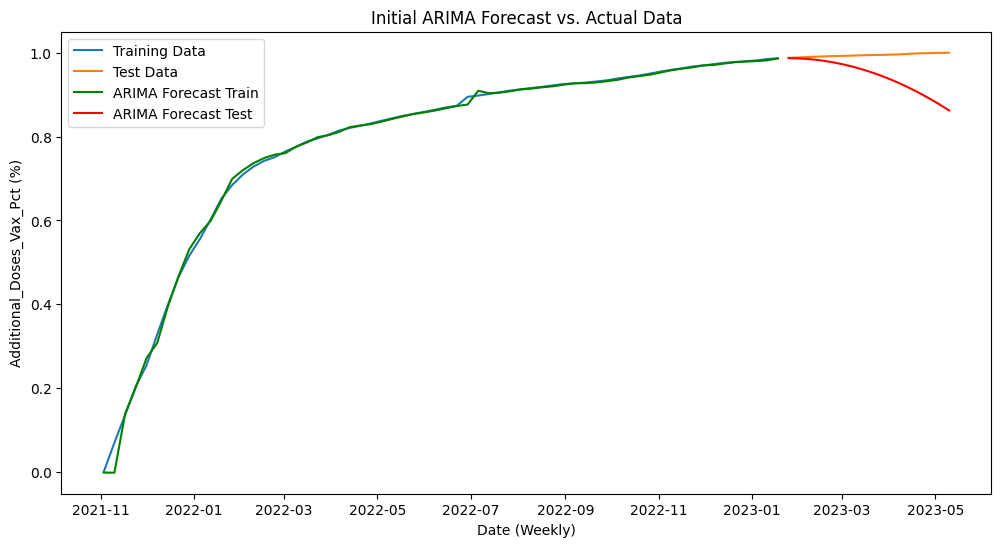

In [ ]:
# Split data into test and train

split_date = int(len(data) * 0.8)
data = data.sort_index(ascending=True)

# Split the data
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]

# stepwise = True, stepwise search, Random Search
base_model = auto_arima(train_data,
                      stationary = False,
                   seasonal = True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(base_model.summary())

# Make predictions on the training set
train_preds = base_model.predict_in_sample()
print('--------------------------------------------------------')
# Print RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(train_data, train_preds))
print(f"RMSE on training set: {train_rmse}")

# Make predictions on the test set
test_preds = base_model.predict(n_periods=len(test_data))

# Print RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(test_data, test_preds))
print(f"RMSE on test set: {test_rmse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(train_data.index, train_preds, label='ARIMA Forecast Train', color='green' )
plt.plot(test_data.index, test_preds, label='ARIMA Forecast Test', color='red')
plt.legend()
plt.title('Initial ARIMA Forecast vs. Actual Data')
plt.xlabel('Date (Weekly)')
plt.ylabel('Additional_Doses_Vax_Pct (%)')
plt.show()

The initial Auto ARIMA model demonstrates strong performance on the training set with a low RMSE of 0.0108, indicating a good fit to the training data. However, the slightly higher RMSE on the test set (0.0665) suggests a need for caution, indicating potential challenges in generalizing the model to new, unseen data (overfitting). To mitigate this I tuned my model with cross validation and performed one day rolling forecast.

In [ ]:
# Determine the split between training and testing data
train_size = int(len(df) * 0.8)  # Adjust the split ratio as needed


# Set the seasonal period to 3 (for a pattern repeating every 3 months)
seasonal_period = 3

# Initialize model
model = auto_arima(train_data, seasonal=True,sttaionary= False, m=seasonal_period)

# Number of days to forecast
num_days = len(test_data)

# One-day rolling forecast loop
forecasts = []
for i in range(num_days):
    # Make one-day forecast
    forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)
    forecasts.append(forecast[0])

    # Update model with the actual value from the test set
    new_observation = test_data.iloc[i]
    model.update(new_observation)

# Get the parameters of the final model
model_params = model.get_params()

# Make forecasts for the entire test set
full_forecast, conf_int = model.predict(n_periods=num_days, return_conf_int=True)

# Calculate RMSE on the test data
rmse = np.sqrt(mean_squared_error(test_data, full_forecast))

# Print or use the RMSE and model parameters
print(f"RMSE on Test Data: {rmse}")
print("Final Model Parameters:")
print(model_params)

# Calculate residuals
residuals = test_data[pred_var] - full_forecast



RMSE on Test Data: 0.056963116842521505
Final Model Parameters:
{'maxiter': 50, 'method': 'lbfgs', 'order': (0, 2, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 3), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}


The method yielded the same order parameters as the initial model (0,2,1). I was surprised that the test RMSE (0.05) was not significantly lower than that of the initial model. Despite Auto ARIMA automatically selecting the best model, these results suggest it may not capture certain trends and information accurately. To explore this further, I ran a SARIMAX model. I suspected that the subpar performance on the test data was due to the automatic nature of Auto ARIMA. With a small dataset of only 80 entries, automatic model fitting can be too complex and lead to overfitting. SARIMAX, is a specific modeling approach accommodating seasonality and exogenous variables, provides more manual control. Although SARIMAX necessitates manual tuning, I anticipated it could more accurately capture the seasonal trends in the data.

In [ ]:
### SARIMAX

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product
from tqdm import tqdm

# Load your time series data (assuming it's in a variable called 'data')
# Define the parameter grid
p = d = q = range(0, 3)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assuming seasonality of 12, change accordingly

# Split the data into training and validation sets
train_size = int(len(train_data) * 0.8)
train, valid = train_data[0:train_size], train_data[train_size:]

# Perform cross-validation on the training set
best_score, best_params = float('inf'), None
best_residuals = None
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
            results = model.fit(disp=False)
            predictions = results.get_forecast(len(valid)).predicted_mean
            residuals = valid - predictions
            mse = mean_squared_error(valid, predictions)
            if mse < best_score:
                best_score, best_params = mse, (param, param_seasonal)
                best_residuals = residuals
        except Exception as e:
            print(f"Error for {param}, {param_seasonal}: {e}")

# Refit the model on the full training set with the best parameters
best_model = SARIMAX(data, order=best_params[0], seasonal_order=best_params[1])
final_results = best_model.fit(disp=False)

# Evaluate on a separate test set if available
test_size = len(test_data)
test_predictions = final_results.get_forecast(test_size).predicted_mean
test_residuals = test_data[pred_var] - test_predictions
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
print(f"Test RMSE: {test_rmse}")
print(f"Best Params: {best_params}")


 74%|███████▍  | 20/27 [10:24<03:57, 33.88s/it]

Error for (2, 0, 2), (2, 0, 1, 12): LU decomposition error.


100%|██████████| 27/27 [14:54<00:00, 33.13s/it]


Test RMSE: 0.011985831817265362
Best Params: ((0, 1, 2), (0, 0, 2, 12))


### Final Model

Test RMSE: 0.0011769549468767899


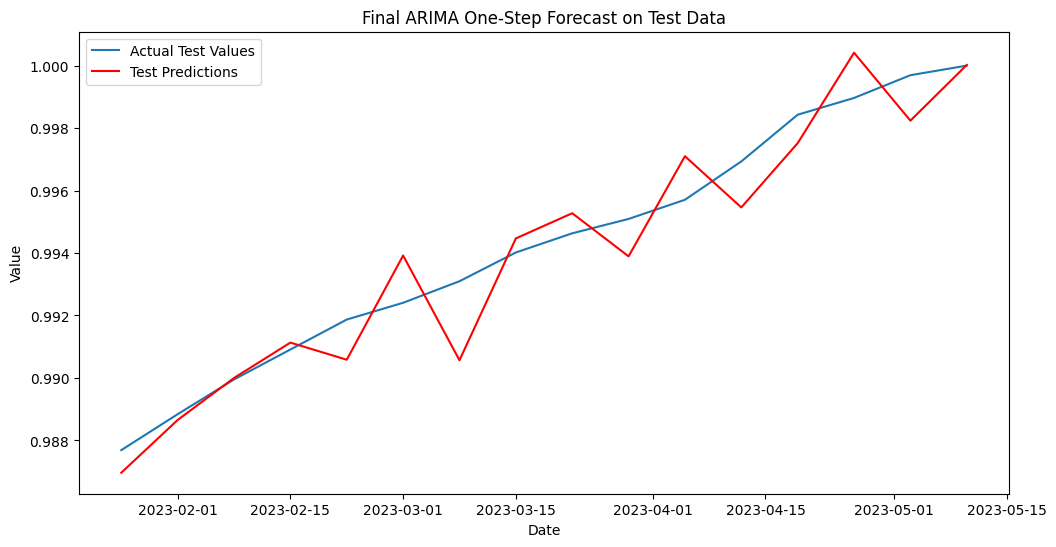

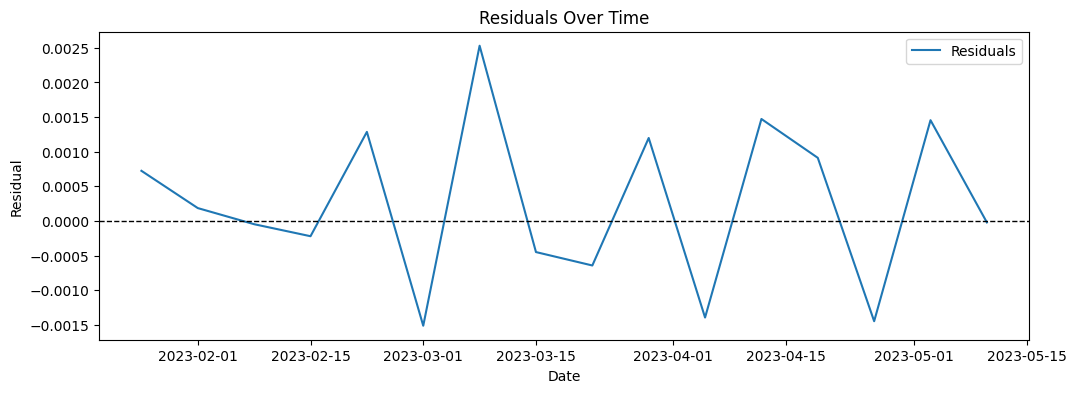

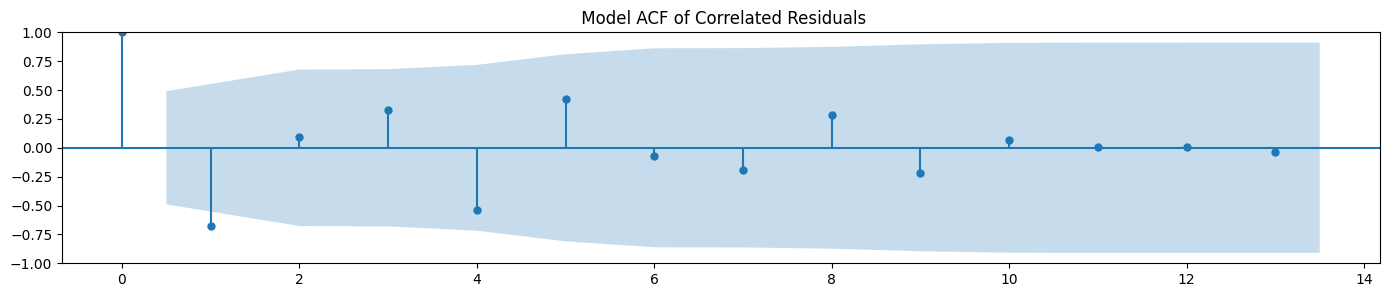

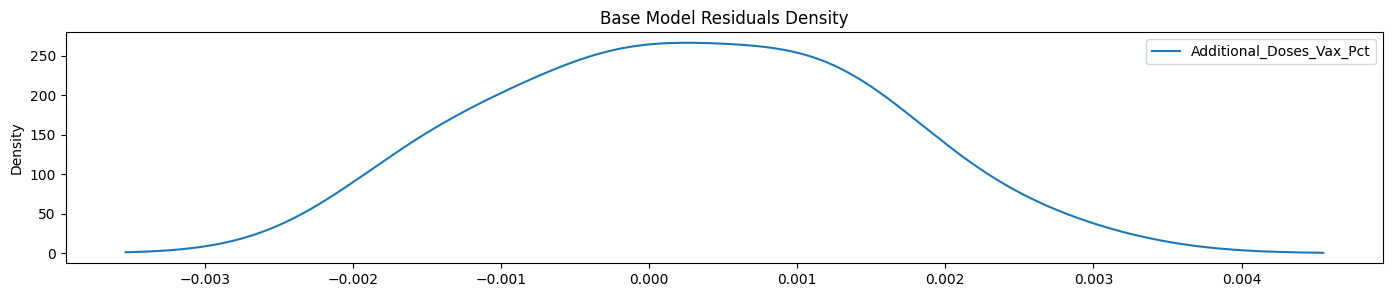

In [ ]:
### Final ARIMA Model

order = (0, 1, 2)
seasonal_order = (0, 0, 2, 12)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Fit the SARIMAX model
model = SARIMAX(endog=train_data, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
# Fit ARIMA model on the training data
# model = ARIMA(train_data, order=(1, 1, 0))
# model_fit = model.fit()
train_size = len(train_data.values)
# Initialize empty lists to store predictions and residuals
predictions = []
residuals = []

# Perform rolling one-step forecast on the test data
for i in range(len(test_data)):
    # Fit the model on the available training data
    model = SARIMAX(data[:train_size + i], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Make a one-step forecast
    yhat = model_fit.forecast(steps=1)[0]

    # Append the prediction to the list
    predictions.append(yhat)

    # Append the residual to the list
    residuals.append(test_data.iloc[i] - yhat)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(test_data, predictions))
print(f"Test RMSE: {rmse}")

# Plot the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Test Values')
plt.plot(test_data.index, predictions, label='Test Predictions', color='red')
plt.title('Final ARIMA One-Step Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the residuals over time
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, residuals, label='Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

residuals = pd.DataFrame(residuals)
# Residuals ACF
plt.figsize=(10, 8)
acf_original = plot_acf(residuals)
plt.title(" Model ACF of Correlated Residuals")
plt.show()

# Residual Density
residuals.plot(kind='kde', title='Base Model Residuals Density')
plt.show()

The ultimate model selection, determined by evaluating root mean square error (RMSE) and overall performance, resulted in the adoption of the SARIMAX model with a one-day rolling forecast. This particular configuration exhibited superior test RMSE compared to the auto_arima models. The finalized parameters for the SARIMAX model were set as follows: order = (0, 1, 2), seasonal_order = (0, 0, 2, 12).

Upon scrutinizing the plots depicting predicted test values and the corresponding residuals, it is evident that the model adeptly generalizes to unseen data, signifying its resilience against overfitting. However, the residual density deviates from a perfect normal distribution, and there is observable variance in residuals over time, indicating potential trends in the data that the model may not fully capture.

Despite achieving an impressive Test RMSE of 0.001, the SARIMAX model did not outperform the ARIMA model, which yielded a Test RMSE of 0.0003. This outcome was anticipated, given that while SARIMAX could better accommodate seasonal patterns than ARIMA, its increased complexity, akin to auto_arima, poses a risk of overfitting, especially considering the limited size of the dataset.

## Prophet (Univariate)

### Data Preparation

Prophet offers distinct advantages over ARIMA models in time series forecasting. Notably, deals much better with handling missing data, accommodating holidays and special events seamlessly, and providing an intuitive parameter tuning process. Prophet is an Additive Regressive Model, its architecture employs a piecewise linear function for trend modeling with automatic changepoint detection, Fourier series for seasonality representation, and explicit incorporation of holidays. Key parameters like changepoint_prior_scale and seasonality_prior_scale allow users to control the model's flexibility and strength of seasonality.

Equation:
**y(t) = g(t) + h(t) + s(t) + et**

Where:
- y(t): Additive Regressive Model
- g(t): Trend Factor
- h(t): Holiday component
- s(t): Seasonality Component
- et: Error term

The dataset preparation for the Prophet (univariate) model closely mirrors the procedures I've employed for ARIMA models. The initial step involved grouping the data by date, ensuring a chronological order. Subsequently, I've scaled the dataset accordingly.

The primary data transformation necessary for compatibility with the Prophet (univariate) model involved the formatting of the input features. Specifically, the 'Date' column and the variable to be predicted need to be included in the dataset and named 'ds' and 'y', respectively. This specific naming convention is imperative, as the Prophet model expects data to adhere to these precise column names. By conforming to this requirement, I ensured that the model correctly interprets the time information in the 'ds' column and the corresponding target variable in the 'y' column.


In [ ]:
#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf

import warnings

# Suppress specific warning types
warnings.filterwarnings("ignore")

pred_var = 'Additional_Doses_Vax_Pct'

df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()

#subset data to be only dates and predicting variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data_w = data.resample('W').sum()

#scaling data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data_w), columns=data.columns, index=data_w.index)
data = data.reset_index()

### Model Building

In [ ]:
# Split data into test and train
split_date = int(len(data) * 0.8)
data = data.sort_values(by ='Date',ascending=True)
# Split the data
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]
# indentify forecast date
forecast_start_dt = date(2023,1,29) #data set ends of (2023,1,29)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
#print(forecast_start_date)
prediction_days = 16

Following a methodology similar to that employed for ARIMA models, I partitioned the data into training and testing sets. Subsequently, I constructed an initial Prophet model using default parameter values.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyk4odigv/53t6kil3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyk4odigv/m58ofj96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77445', 'data', 'file=/tmp/tmpyk4odigv/53t6kil3.json', 'init=/tmp/tmpyk4odigv/m58ofj96.json', 'output', 'file=/tmp/tmpyk4odigv/prophet_modelhaeeh1vj/prophet_model-20231126230451.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:04:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:04:51 - cmdstanpy - INFO - Chai

Train RMSE: 0.0030205145886325166
Test RMSE: 0.02683607297706949


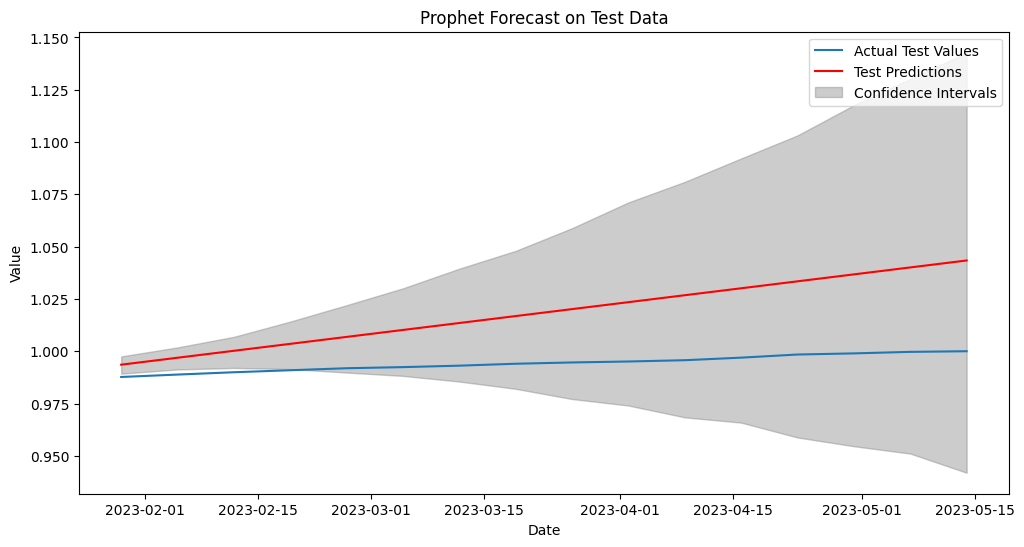

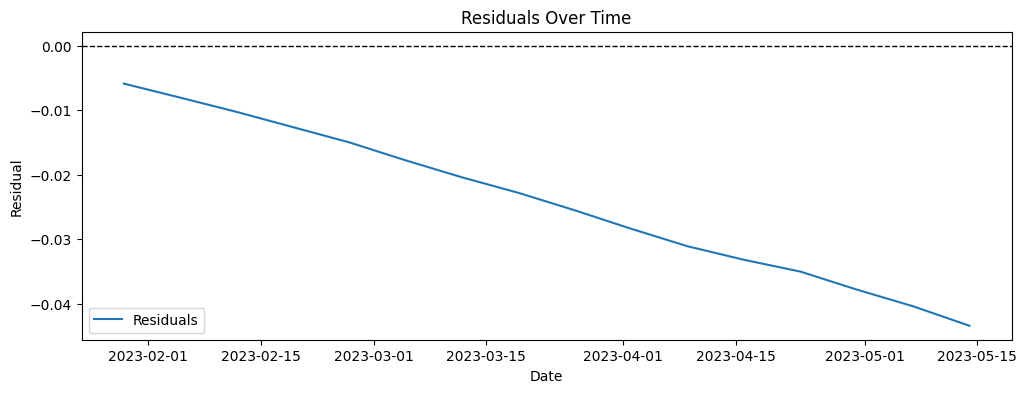

<Figure size 1000x800 with 0 Axes>

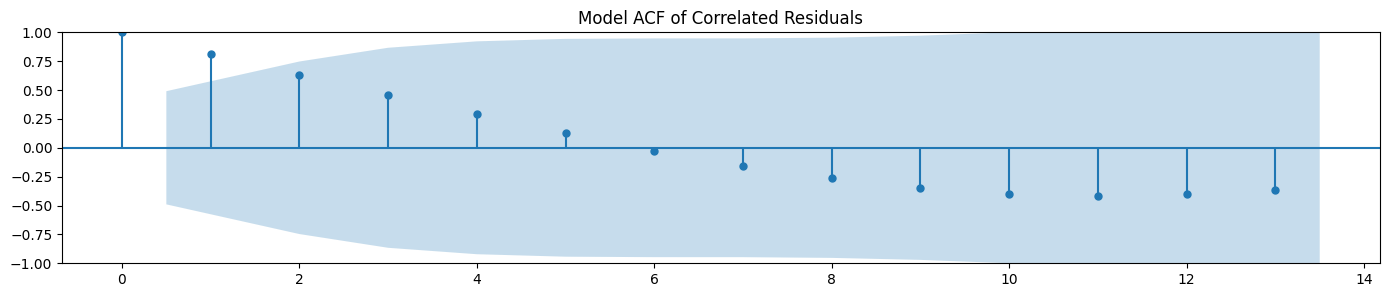

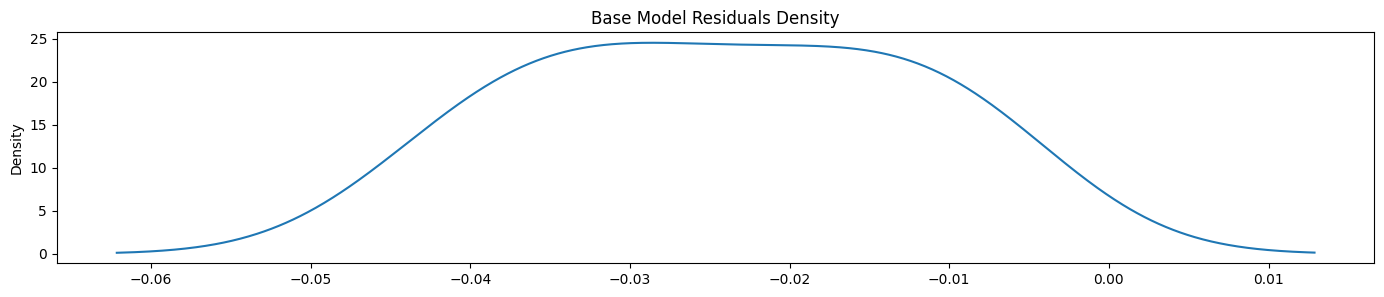

In [ ]:
def train_prophet_model(train_data):
    m = Prophet()
    m.fit(train_data)
    return m

def make_predictions(model, future_data):
    forecast = model.predict(future_data)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

def calculate_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))

def plot_forecast(test_data, predicted_data):
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['ds'], test_data['y'], label='Actual Test Values')
    plt.plot(predicted_data['ds'], predicted_data['yhat'], label='Test Predictions', color='red')
    plt.fill_between(predicted_data['ds'], predicted_data['yhat_lower'], predicted_data['yhat_upper'], color='gray', alpha=0.4, label='Confidence Intervals')
    plt.title('Prophet Forecast on Test Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_residuals(predicted_data):
    plt.figure(figsize=(12, 4))
    plt.plot(predicted_data['ds'], predicted_data['residuals'], label='Residuals')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

def plot_residual_acf(predicted_data):
    plt.figure(figsize=(10, 8))
    acf_original = plot_acf(predicted_data['residuals'])
    plt.title("Model ACF of Correlated Residuals")
    plt.show()

def plot_residual_density(predicted_data):
    predicted_data['residuals'].plot(kind='kde', title='Base Model Residuals Density')
    plt.show()

# Assuming 'Date' and 'y' are your date and target columns
df_copy = data.copy()
df_copy = df_copy.rename(columns={'Date': 'ds', pred_var: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

# Split the data into training and test sets
train_set = df_copy[df_copy['ds'] < forecast_start_date]
test_set = df_copy[df_copy['ds'] >= forecast_start_date]

# Train the model
model = train_prophet_model(train_set)

# Make future dataframe for predictions
future = model.make_future_dataframe(periods=len(test_set), freq='W')
forecast = make_predictions(model, future)

# Storing values for visualization and residuals
predicted_df = pd.merge(test_set[['ds', 'y']], forecast, on='ds')
predicted_df['residuals'] = predicted_df['y'] - predicted_df['yhat']

# Calculate Train RMSE
rmse_train = calculate_rmse(train_set['y'], model.predict(train_set)['yhat'])
print(f"Train RMSE: {rmse_train}")

# Calculate Test RMSE
rmse_test = calculate_rmse(predicted_df['y'], predicted_df['yhat'])
print(f"Test RMSE: {rmse_test}")

# Plot forecast
plot_forecast(test_set, predicted_df)

# Plot residuals
plot_residuals(predicted_df)

# Plot residual ACF
plot_residual_acf(predicted_df)

# Plot residual density
plot_residual_density(predicted_df)


The baseline Prophet model, trained with default parameters, exhibits a remarkably low Train RMSE of 0.003, indicating a close fit to the training data. However, the Test RMSE of 0.02, while relatively low, suggests a noticeable difference in performance between the training and test sets, hinting at potential overfitting or a challenge in generalization to unseen data. The plot of actual vs. predicted test values reveals a consistent overestimation trend by the model, indicating a systematic bias. Notably, the widening confidence intervals over time signal a growing uncertainty in long-term predictions.

My next step was to implement cross-validation,it will address overfitting and provide a more comprehensive understanding of how a model performs with unseen data. In pursuit of optimal model performance, I executed a parameter grid search, and the corresponding code is available in the appendix. Guided by the outcomes of the initial grid search, I configured my cross-validation strategy to entail training the model on the first week, generating predictions for the subsequent week, and iteratively repeating this cycle with a 2-week interval between each training and evaluation period. This configuration proves apt for evaluating the model's capacity to generalize to short-term predictions, specifically emphasizing a 1-week forecasting horizon. This choice aligns with the nature of the test data set, which spans only 16 weeks, thereby qualifying as a short-term. Furthermore, short-term forecasting proves advantageous for non-stationary data, effectively capturing volatile trends within the dataset.

In the tuning process, I learned about Prophet parameters and realzied they are primarily related to seasonal trends, which based on initial data analysis could strongly influence my data. I conducted a coarse grid search which focused on exploring values for seasonality_prior_scale, holidays_prior_scale, changepoint_prior_scale, and the number of changepoints. The results indicated small values for both seasonality and holidays, aligning with expectations that these factors have minimal impact on the data, especially considering the weekly aggregation. Following this, I refined the parameter range and performed a finer grid search. Notably, I extended the tuning to include the number of changepoints, a factor I believed could significantly affect the model. Changepoints denote abrupt shifts in the time series trajectory, and while the data exhibits a consistent upward trend, small changes were observed to have a notable impact, particularly in early time ranges, as evident from discrepancies in ARIMA model fits.

1. **`seasonality_prior_scale` (float):**
   - Controls the strength of the seasonality model. Higher values allow the model to fit the training data more closely but may lead to overfitting.

2. **`holidays_prior_scale` (float):**
   - Controls the strength of the holiday effects. Similar to `seasonality_prior_scale`, it adjusts the impact of holidays on the model.

3. **`changepoint_prior_scale` (float):**
   - Controls the flexibility of the trend. A higher value makes the trend more flexible, capturing more short-term fluctuations, but it can lead to overfitting.

4. **`n_changepoints` (int):**
   - Number of potential changepoints to include. The default is 25, but you can adjust this to capture more or fewer potential changepoints.

In [ ]:
#Supress default INFO logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [ ]:
import logging
logging.basicConfig(level=logging.CRITICAL)

# Assuming df is your DataFrame with columns 'ds' and 'ytrue'
df = data.copy()
df.columns = ['ds', 'y']

# Split the data into training and test sets
train_size = int(0.8 * len(df))
train_set = df[:train_size]
test_set = df[train_size:]

# Specify the number of days in a week for the weekly seasonality
days_in_week = 7

# Define hyperparameter values to try
seasonality_prior_scale_values = [0.01, 0.1, 0.5]
holidays_prior_scale_values = [0.01, 0.1, 0.5]
changepoint_prior_scale_values = [0.01, 0.1, 0.5]
n_changepoints_values = [10, 20, 30]  # Adjust the range as needed

best_params = None
best_rmse = float('inf')

# Iterate over hyperparameter values
for seasonality_prior_scale in seasonality_prior_scale_values:
    for holidays_prior_scale in holidays_prior_scale_values:
        for changepoint_prior_scale in changepoint_prior_scale_values:
            for n_changepoints in n_changepoints_values:
                # Initialize the Prophet model with hyperparameters
                m = Prophet(
                    weekly_seasonality=True,
                    yearly_seasonality=False,
                    seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale,
                    changepoint_prior_scale=changepoint_prior_scale,
                    n_changepoints=n_changepoints
                )

                # Fit the model on the training dataset
                m.fit(train_set)

                # Perform cross-validation on the training data
                df_cv = cross_validation(m, initial='1 W', period='2 W', horizon='1 W')

                # Compute performance metrics on the training data
                df_metrics = performance_metrics(df_cv)

                # Track the best hyperparameters based on training data performance
                avg_rmse = df_metrics['rmse'].mean()
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_params = {
                        'seasonality_prior_scale': seasonality_prior_scale,
                        'holidays_prior_scale': holidays_prior_scale,
                        'changepoint_prior_scale': changepoint_prior_scale,
                        'n_changepoints': n_changepoints
                    }




In [ ]:
print("Best Hyperparameters (Training Data):", best_params)

Best Hyperparameters (Training Data): {'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.5, 'n_changepoints': 30}


The above are the best Hyperparamters after performing grid search with cross validation. It is suprising to see that the seasonal related paramteres are at the lowest value as data previously showed seasonality.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6q0h5g2a/xk1zwrnz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6q0h5g2a/od_z462d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22469', 'data', 'file=/tmp/tmp6q0h5g2a/xk1zwrnz.json', 'init=/tmp/tmp6q0h5g2a/od_z462d.json', 'output', 'file=/tmp/tmp6q0h5g2a/prophet_modelmprtwcag/prophet_model-20231127011948.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:19:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training RMSE: 0.0022174022690210683
Test RMSE: 0.02445351626447273


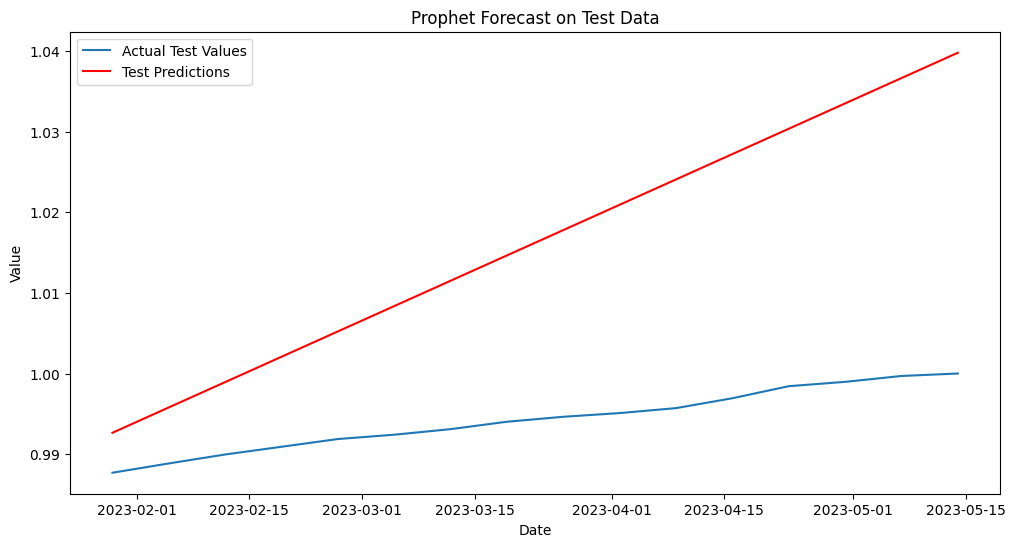

Text(0.5, 0, 'Date')

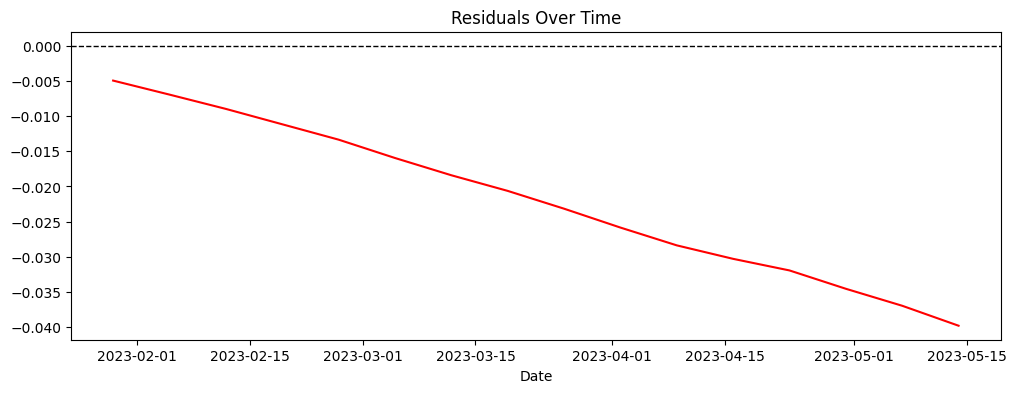

In [ ]:
best_params = {'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.5, 'n_changepoints': 30}
# Assuming df is your DataFrame with columns 'ds' and 'y'
df_copy = data.copy()
df_copy.columns = ['ds', 'y']

# Split the data into training and test sets
train_size = int(0.8 * len(df_copy))
train_data = df_copy[:train_size]
test_data = df_copy[train_size:]

# Initialize and fit the Prophet model on the training data
final_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    n_changepoints= best_params['n_changepoints']
)

final_model.fit(train_data)

# Make future dataframe for predictions
future = final_model.make_future_dataframe(periods=len(test_data), freq='W')

# Generate predictions for both training and test data
fcst_prophet = final_model.predict(future)

# Filter to only include the forecasted data into predicted_df
filter_train = fcst_prophet['ds'] < test_data['ds'].min()
filter_test = (fcst_prophet['ds'] >= test_data['ds'].min()) & (fcst_prophet['ds'] <= test_data['ds'].max())

predicted_df_train = fcst_prophet[filter_train][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predicted_df_test = fcst_prophet[filter_test][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Merge with actual values for both training and test data
df_copy_train = train_data.copy()
df_copy_train.columns = ['ds', 'ytrue']
df_copy_test = test_data.copy()
df_copy_test.columns = ['ds', 'ytrue']

predicted_df_train = pd.merge(df_copy_train, predicted_df_train, on='ds')
predicted_df_test = pd.merge(df_copy_test, predicted_df_test, on='ds')

# Calculate RMSE for training data
rmse_train = np.sqrt(mean_squared_error(predicted_df_train['ytrue'], predicted_df_train['yhat']))
print(f"Training RMSE: {rmse_train}")

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(predicted_df_test['ytrue'], predicted_df_test['yhat']))
print(f"Test RMSE: {rmse_test}")

# Plot the predictions and actual values for both training and test data
plt.figure(figsize=(12, 6))
plt.plot(predicted_df_test.ds, predicted_df_test.ytrue, label='Actual Test Values')
plt.plot(predicted_df_test.ds, predicted_df_test.yhat, label='Test Predictions', color='red')
plt.title('Prophet Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the residuals over time for both training and test data
plt.figure(figsize=(12, 4))
plt.plot(predicted_df_test.ds, predicted_df_test.ytrue - predicted_df_test.yhat, label='Test Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Date')


The final univariate Prophet model, tuned with hyperparameters through cross-validation, demonstrated a training RMSE of 0.0022 and a test RMSE of 0.0245. The graphical analysis of predicted versus actual values revealed an elevated prediction line with a more pronounced positive slope, indicating a potential bias or overestimation in the model's predictions. Morover the plot of residuals overtime suggests the presence of systematic deviations from randomness, indicating potential inadequacies in capturing temporal dependencies or trends in the data. Despite the model's success in fitting the training data, there is room for improvement in terms of generalization to unseen data and addressing underlying patterns in residuals.

During the tuning process of the univariate Prophet model, I encountered challenges in accurately identifying the seasonal patterns and trends within the data. Despite prior data exploration indicating the presence of trends, the tuning procedure minimized parameters associated with seasonality. This adjustment, while optimizing certain aspects, may have inadvertently led to limitations in capturing the true seasonal dynamics, potentially influencing the final performance of the model. The difficulty in fine-tuning seasonality-related parameters underscores the intricacies involved in effectively modeling time-series data with Prophet.

## Prophet Multivariate

### Data Preparation

I applied consistent data preparation methods, mirroring those used in previous instances. The foundation of my Prophet Multivariate Model was built upon the scaled dataframe derived from the Prophet Univariate Model. Following the same protocol as for the Prophet Univariate Model, I renamed the 'Date' variable to 'ds' and the prediction variable to 'y,' adhering to Prophet's requirements.

In the model development phase, I utilized the entire dataframe encompassing all variables. Previous exploratory data analysis (EDA) indicated strong correlations between all variables and the prediction variable, warranting their inclusion. Additionally, I introduced a lag of 1 week to each of the time series variables based on insights from prior partial autocorrelation function (PACF) plots, which highlighted a prominent lag at a value of 1.

It's worth noting that Prophet lacks explicit feature importance metrics due to its reliance on a specific additive time series decomposition. The contribution of each feature is intricately linked with the overall decomposition, leading to the inclusion of all columns in the dataset in the Prophet Multivariate Model.

In [ ]:
import warnings

# Suppress specific warning types
warnings.filterwarnings("ignore")

pred_var = 'Additional_Doses_Vax_Pct'

df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date').mean()

#subset data to be only dates and predicting variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data_w = data.resample('W').sum()

#scaling data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data_w), columns=data.columns, index=data_w.index)
#data = data.reset_index()

In [ ]:
# selected variables
df = data.copy()

def process(df,lags=[1]):
    ret=df[[pred_var]]
    for lag in lags:
        lagdf = df.shift(lag)
        lagdf.columns=[f'lag{lag}_' + str(col) for col in lagdf.columns]
        ret=pd.concat([ret, lagdf], axis=1)
    return ret.fillna(0)
data=process(df, lags=[1,2,3])

# Check for duplicate columns
duplicates = data.columns[data.columns.duplicated()]

# Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

### Model Building

I maintained consistency in the test/train split, following the same approach as before. To initiate the modeling process, I started by fitting an initial Prophet model, incorporating all columns as regressors.

In [ ]:
split_date = int(len(data) * 0.8)
data = data.reset_index()
data = data.sort_values(by ='Date',ascending=True)
data = data.rename(columns={'Date': 'ds', 'Additional_Doses_Vax_Pct': 'y'})
# Split the data
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]


In [ ]:
model = Prophet()
for col in train_data.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)
# Fit the model on the training data
model.fit(train_data)

# Make predictions on the training set
train_predictions = model.predict(train_data)

# Make predictions on the test set
test_predictions = model.predict(test_data)

# Extract the actual and predicted values
train_actual = train_data['y']
test_actual = test_data['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6q0h5g2a/nfva4znw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6q0h5g2a/qnqk3cpi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37540', 'data', 'file=/tmp/tmp6q0h5g2a/nfva4znw.json', 'init=/tmp/tmp6q0h5g2a/qnqk3cpi.json', 'output', 'file=/tmp/tmp6q0h5g2a/prophet_modeltd6tywla/prophet_model-20231127013341.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:33:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:43 - cmdstanpy - INFO - Chai

Training RMSE: 1.6622257945163467e-05
Testing RMSE: 4.2351498180102505


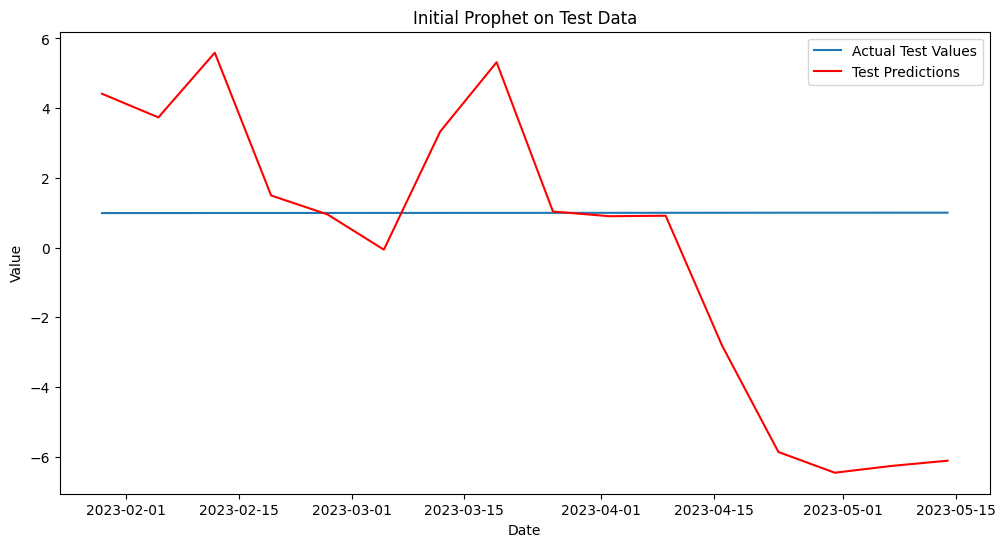

In [ ]:
# Plot the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.ds, test_data.y, label='Actual Test Values')
plt.plot(test_data.ds, test_pred, label='Test Predictions', color='red')
plt.title('Initial Prophet on Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

The initial model exhibited pronounced overfitting, as evidenced by a Training RMSE of 1.6622e-05 and a considerably higher Testing RMSE of 4.2351. This disparity indicates a lack of adaptability to unseen data, which is further supported by the visual representation in the accompanying plot. The plot illustrates substantial deviations between the predicted values and the actual values, underscoring the model's struggle to generalize effectively beyond the training data.

In an effort to enhance the model's performance, I conducted a grid search with cross-validation to fine-tune its hyperparameters. Analogous to previous iterations, my focus was on optimizing parameters such as 'changepoint_prior_scale,' 'seasonality_prior_scale,' and 'holiday_prior_scale.' Additionally, I introduced 'seasonality_mode' into the tuning process. In the context of Multivariate Prophet, 'seasonality_mode' refers to a parameter that controls how seasonality components are incorporated. It can take values such as 'additive' or 'multiplicative,' influencing the manner in which seasonal effects are added to the overall time series. This extension in the hyperparameter tuning process aimed to comprehensively optimize the model's ability to capture the intricacies of the data, particularly considering the multivariate nature of the dataset.

Thr code for the paramter tunning can be found in the appendix. The parameters I used for the final model based on the grid search were:
**{changepoint_prior_scale : 0.5, seasonality_prior_scale : 0.01,holidays_prior_scale : 0.01, seasonality_mode : 'additive'}**

In [ ]:
model = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.01,
                     holidays_prior_scale = 0.01, seasonality_mode = 'additive')
for col in train_data.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)
# Fit the model on the training data
model.fit(train_data)

# Make predictions on the training set
train_predictions = model.predict(train_data)

# Make predictions on the test set
test_predictions = model.predict(test_data)

# Extract the actual and predicted values
train_actual = train_data['y']
test_actual = test_data['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6q0h5g2a/v9jn4ejs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6q0h5g2a/ud2tda2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97353', 'data', 'file=/tmp/tmp6q0h5g2a/v9jn4ejs.json', 'init=/tmp/tmp6q0h5g2a/ud2tda2h.json', 'output', 'file=/tmp/tmp6q0h5g2a/prophet_modelclvcaz1y/prophet_model-20231127033012.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:30:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:38:32 - cmdstanpy - INFO - Chai

Training RMSE: 3.182828819620475e-07
Testing RMSE: 0.046661093948509036


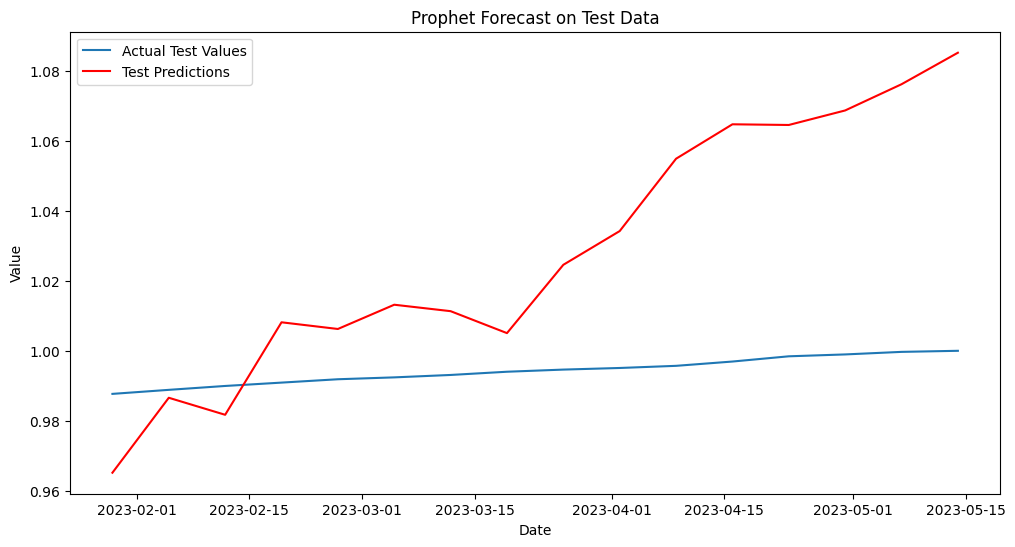

Text(0.5, 0, 'Date')

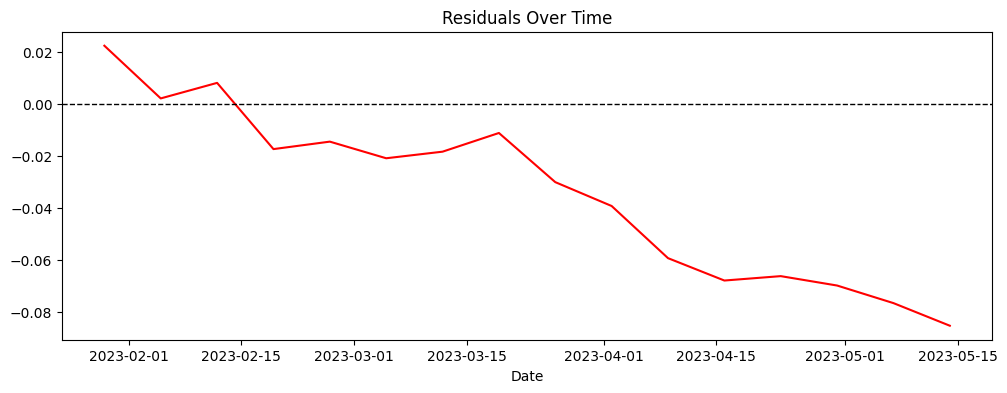

In [ ]:
# Plot the predictions and actual values for both training and test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.ds, test_data.y, label='Actual Test Values')
plt.plot(test_data.ds, test_pred, label='Test Predictions', color='red')
plt.title('Prophet Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the residuals over time for both training and test data
plt.figure(figsize=(12, 4))
plt.plot(test_data.ds, test_data.y.values - test_pred, label='Test Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Date')

In comparing the baseline and final iterations of the Prophet multivariate model, significant improvements were observed after parameter tuning. The baseline model exhibited Training RMSE of 1.66e-05 and Testing RMSE of 4.24, while the final tuned model achieved a remarkable Training RMSE of 3.18e-07 and Testing RMSE of 0.05. Despite the enhanced performance, it's noteworthy that the test predictions line displayed a distinct behavior and slope compared to the actual test values. Furthermore, the residuals over time formed a jagged line with a downward trend, suggesting that the model may still struggle to capture certain dynamic patterns in the data.
Dealing with feature selection challenges and extensive tuning times in the Prophet Multivariate model posed significant hurdles. Identifying a streamlined approach for feature selection proved elusive, making it challenging to discern which features were most relevant for the model. Additionally, the time-consuming nature of the tuning process, exacerbated by the data size and parameter range, resulted in each tuning iteration taking multiple hours. This limitation constrained the ability to fine-tune the model to achieve optimal performance. These challenges underscore the importance of efficient feature selection methods and strategies to expedite the tuning process, particularly when working with large datasets and intricate parameter configurations.

## XGBoost

### Data Preparation

XGBoost, short for Extreme Gradient Boosting, is a powerful and versatile machine learning algorithm that belongs to the gradient boosting family. XGBoost builds an ensemble of decision trees sequentially, with each subsequent tree correcting errors made by the previous ones. It incorporates regularization techniques, parallel processing, and efficient algorithms to optimize training speed and enhance predictive accuracy.
Same as before, I scaled the data. For the development of the XGBoost model, I created two datasets—one grouped by date and one ungrouped. I did this because, for all my previous models, I used grouped data and wanted to investigate which dataset would yield better XGBoost performance.


In [ ]:
#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays


from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf

import xgboost as xgb

import warnings

# Suppress specific warning types
warnings.filterwarnings("ignore")

pred_var = 'Additional_Doses_Vax_Pct'

df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date').mean()

#subset data to be only dates and predicting variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data_w = data.resample('W').sum()

#scaling data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data_w), columns=data.columns, index=data_w.index)
data = data.reset_index()
data = data.sort_values(by ='Date',ascending=True)

The data set had over 80 variables, to see if i could narrow down the number of selectors further I used Spearman correlation. I used this method as it checks for correlation but does not assume linear relationship unlike other correlation metrics. This was necessary as I knew many of my variables were not normally distributed. I decided to move forward with all variables that had correlation greater than 0.8 with the prediction variable. I found that to be a good threshold that allowed me to keep a majority of strongly correlated variables. This left me with 59 features.

In [ ]:
from scipy.stats import spearmanr

df = data.copy()

# Exclude 'date' column from correlation calculation
numeric_columns = df.select_dtypes(include=['float64']).columns
correlations = df[numeric_columns].apply(lambda x: spearmanr(x, df[pred_var]).correlation)

# Rank features based on absolute correlation values
ranked_features = correlations.abs().sort_values(ascending=False)

# Filter columns with correlation >= 0.8
selected_features = correlations[correlations.abs() >= 0.8].index.tolist()
#print("Selected Features:", selected_features)

selected_features_pred = selected_features + [pred_var,'Date']


On the subsetted data comprising 59 variables, I incorporated lag values of 1, 2, and 3 weeks for each time series variable. The determination of these lag values was informed by prior data exploration, during which I identified that the data exhibits the strongest correlation with values closest in date proximity.

In [ ]:
# selected variables
df = data[selected_features_pred]
df = df.set_index('Date')

def process(df,lags=[1]):
    ret=df[[pred_var]]
    for lag in lags:
        lagdf = df.shift(lag)
        lagdf.columns=[f'lag{lag}_' + str(col) for col in lagdf.columns]
        ret=pd.concat([ret, lagdf], axis=1)
    return ret.fillna(0)
data=process(df, lags=[1,2,3])

# Check for duplicate columns
duplicates = data.columns[data.columns.duplicated()]

# Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

### Model Development

### Grouped Data

I initially constructed a base XGBoost model with default parameters to assess its performance on my dataset. Similar to my approach with other models, I divided the data into an 80/20 train-test split. To evaluate the model's performance, I examined the root mean squared error (RMSE) on both the test and train sets, in addition to analyzing the residuals.

In [ ]:
# Split the data into test and train

split_date = int(len(data) * 0.8)
data = data.sort_values(by ='Date',ascending=True)
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]

In [ ]:
def train_and_evaluate_xgboost(train_data, test_data, params):
    # Extract features and target variables
    X_train, y_train = train_data.drop(pred_var, axis=1), train_data[pred_var]
    X_test, y_test = test_data.drop(pred_var, axis=1), test_data[pred_var]

    # Convert the data into DMatrix format (XGBoost's internal data structure)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    # Train the XGBoost model
    num_rounds = 100  # Number of boosting rounds (you can adjust this parameter)
    model = xgb.train(params, dtrain, num_rounds)

    feature_importance = model.get_fscore()  # Alternative: model.get_booster().get_score()
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    # Make predictions on the training set
    y_train_pred = model.predict(dtrain)

    # Make predictions on the test set
    y_test_pred = model.predict(dtest)

    # Evaluate the model on training set
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

    # Evaluate the model on test set
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    return train_rmse, test_rmse, feature_importance, y_test_pred

# Base Model
# Set XGBoost parameters
params = {
        'objective': 'reg:squarederror',  # Regression task with mean squared error loss
        'eval_metric': 'rmse'  # Root Mean Squared Error as the evaluation metric
    }

train_rmse, test_rmse, feature_importance, y_test_pred = train_and_evaluate_xgboost(train_data, test_data, params)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Training RMSE: 0.0007032582105810476
Test RMSE: 0.011624574454761423


The baseline model showed good performance with Training RMSE: 0.000703 and Test RMSE: 0.0116.
I obtained the feature importance for the initial model with the intention of refining my variable selection before proceeding with hyperparameter tuning. Given the limited size of the dataset and past challenges associated with overfitting, the rationale behind narrowing down the number of potential predictors is to mitigate the risk of overfitting. By reducing the number of variables, the model becomes less prone to memorizing noise or idiosyncrasies present in the training data, a consideration particularly crucial in the context of a smaller dataset.

In [ ]:
feature_importance
columns = [x for x,y in feature_importance] + [pred_var]
columns

['lag1_Distributed',
 'lag1_Additional_Doses_Unk_Manuf',
 'lag1_Series_Complete_Janssen_65Plus',
 'lag1_Series_Complete_65PlusPop_Pct',
 'lag2_Series_Complete_Janssen_65Plus',
 'lag1_Distributed_Moderna',
 'lag1_Additional_Doses_Vax_Pct_1_w_lag',
 'lag2_Administered_Dose1_Recip_12PlusPop_Pct',
 'lag2_Additional_Doses_Unk_Manuf',
 'lag2_Additional_Doses_Vax_Pct_1_w_lag',
 'lag1_Series_Complete_Unk_Manuf_65Plus',
 'lag3_Additional_Doses_Janssen',
 'lag3_Additional_Doses_Unk_Manuf',
 'lag1_Distributed_Pfizer',
 'lag1_Administered',
 'lag1_Administered_Unk_Manuf',
 'lag1_Series_Complete_Janssen',
 'lag1_Additional_Doses_Janssen',
 'lag2_Administered_Janssen',
 'lag3_Additional_Doses_Vax_Pct_1_w_lag',
 'lag1_Distributed_Per_100k_65Plus',
 'lag2_Series_Complete_Unk_Manuf_65Plus',
 'lag3_Distributed_Janssen',
 'lag3_Distributed_Moderna',
 'lag3_Administered_Janssen',
 'lag3_Administered_Dose1_Recip_12PlusPop_Pct',
 'Additional_Doses_Vax_Pct']

Based on the performance of the base model I tunned the hyperparamters with grid search to mitigate overfitting and enhance model generalization. The base model, with a training RMSE of 0.0006 and a test RMSE of 0.011, demonstrates a risk of overfitting, as the model performs exceptionally well on the training set but struggles to generalize to unseen data. Grid search systematically explores various combinations of hyperparameter values, such as learning rate, tree depth, and regularization parameters, seeking the configuration that minimizes overfitting and yields the optimal model performance. By tuning these hyperparameters, my aim was to balance between model complexity and generalization, ensuring that the model learns meaningful patterns without fitting noise. This iterative process not only helps in achieving better predictive accuracy on unseen data but also fosters a more robust and reliable model that can be confidently deployed in real-world scenarios. My goal was to improve the model's ability to capture underlying patterns in the data while avoiding the pitfalls of overfitting observed in the initial model.

XGBoost model has several key parameters that influence its behavior during training. Here's a concise description of some of the most important ones I decided to tune for my model:

1. **max_depth:**
   - **Description:** Maximum depth of a tree. Increasing `max_depth` makes the model more complex and can lead to overfitting. It represents the maximum depth of the individual trees in the boosting process.

2. **min_child_weight:**
   - **Description:** Minimum sum of instance weight (hessian) needed in a child. It is used to control over-fitting. Higher values make the algorithm more conservative.

3. **subsample:**
   - **Description:** Subsample ratio of the training instance. It represents the fraction of samples used to fit each individual tree. Values between 0.5 and 1.0 are common. Lower values prevent overfitting.

4. **colsample_bytree:**
   - **Description:** Fraction of features (columns) to be randomly sampled for each tree. It specifies the fraction of features that will be randomly sampled for building each tree. Typical values range from 0.5 to 1.0.

5. **eta (learning_rate):**
   - **Description:** Step size shrinkage used to prevent overfitting. It represents the learning rate of the boosting process. Smaller values make the model more robust but require more boosting rounds.

6. **n_estimators:**
   - **Description:** Number of boosting rounds (trees) to be run. It represents the number of trees added to the model. A higher number of trees can improve performance but also increases computation time.

7. **learning_rate:**
   - **Description:** Alias for `eta`. It represents the step size shrinkage used to prevent overfitting. Smaller values make the boosting process more conservative.

8. **reg_alpha (alpha):**
   - **Description:** L1 regularization term on weights. It adds an L1 penalty term on the weights. It helps prevent overfitting by discouraging the learning algorithm from assigning too much importance to a single feature.

9. **reg_lambda (lambda):**
   - **Description:** L2 regularization term on weights. It adds an L2 penalty term on the weights. Similar to `reg_alpha`, it helps prevent overfitting by discouraging the learning algorithm from assigning too much importance to a single feature.





In [ ]:
# grid search to tune hyperparams

train_data = train_data[columns]
test_data = test_data[columns]

X_train, y_train = train_data.drop(pred_var, axis=1), train_data[pred_var]
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Define the parameter grid to search
param_grid = {
    'max_depth': [1,2,3, 5, 7],
    'min_child_weight': [0.5,1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'eta': [0.01, 0.1, 0.2],
    'n_estimators': [10,25, 50, 100,150],
    'learning_rate': [0.001, 0.01, 0.05],
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Create an XGBoost regressor
xg_reg = xgb.XGBRegressor(**params)

# Define mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = RandomizedSearchCV(
    estimator=xg_reg,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)


# Perform grid search to find the best hyperparameters
grid_result = grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding RMSE
print("Best Parameters: ", grid_result.best_params_)
print("Best RMSE: ", np.sqrt(-grid_result.best_score_))

# Get the best model from the grid search
best_model = grid_result.best_estimator_

# You can use this best_model for predictions on the test set
# Assuming you have your test_data DataFrame
X_test, y_test = test_data.drop(pred_var, axis=1), test_data[pred_var]
dtest = xgb.DMatrix(X_test, label=y_test)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
# Evaluate the best model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train RMSE with Best Model: {train_rmse}')
print(f'Test RMSE with Best Model: {test_rmse}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'subsample': 1.0, 'reg_lambda': 0.00031622776601683794, 'reg_alpha': 0.00031622776601683794, 'n_estimators': 150, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.05, 'eta': 0.2, 'colsample_bytree': 0.8}
Best RMSE:  0.03468670551804222
Train RMSE with Best Model: 0.00030860202891660766
Test RMSE with Best Model: 0.009859022864870087


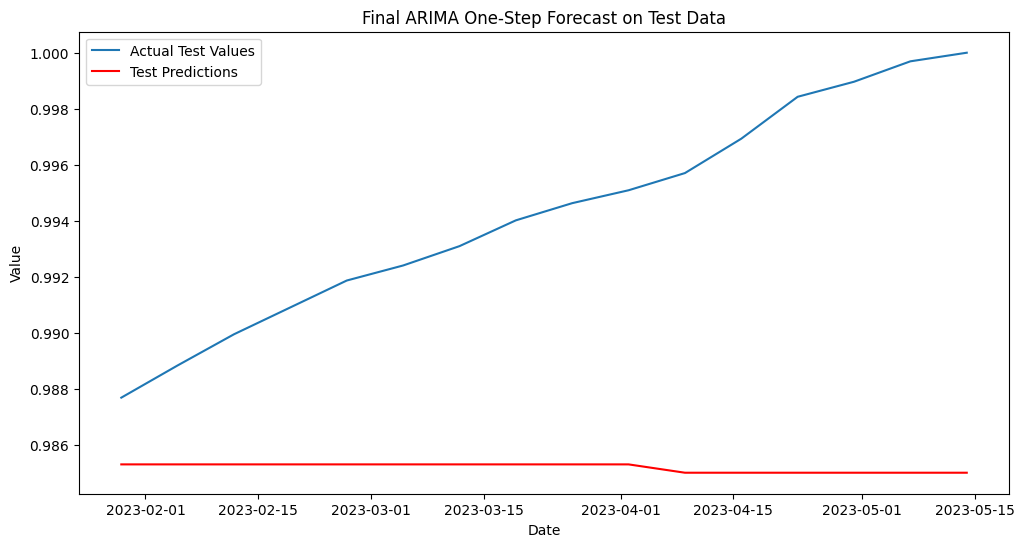

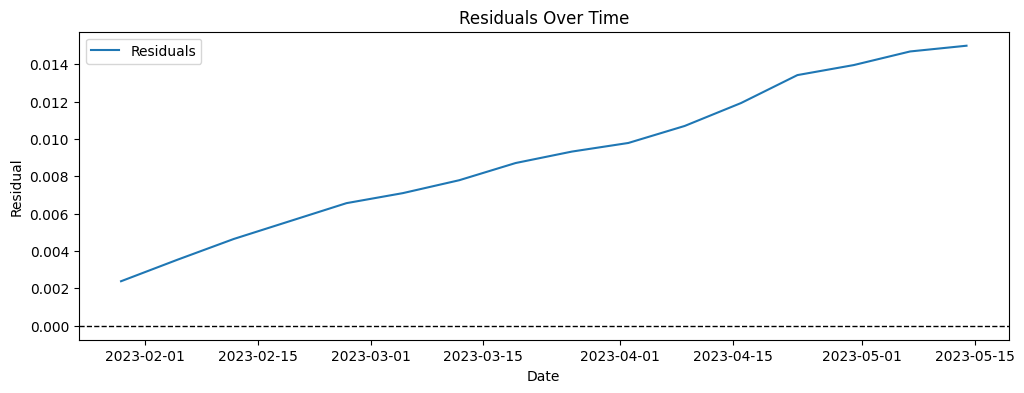

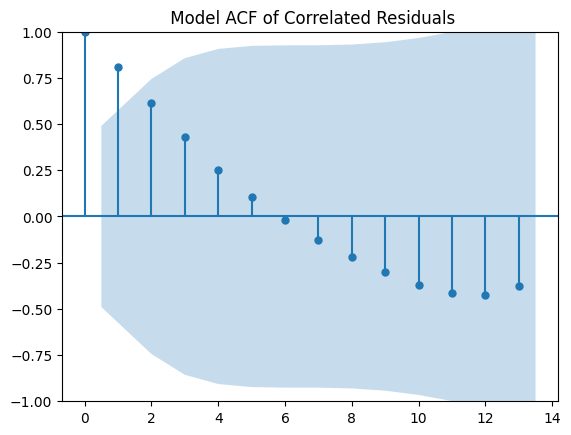

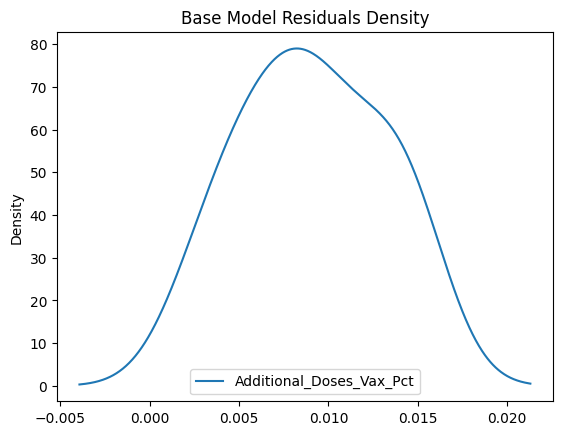

In [ ]:
# Calculate residuals

residuals = y_test - y_test_pred

# Plot the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data[pred_var], label='Actual Test Values')
plt.plot(test_data.index, y_test_pred, label='Test Predictions', color='red')
plt.title('Final ARIMA One-Step Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the residuals over time
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, residuals, label='Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

residuals = pd.DataFrame(residuals)
# Residuals ACF
plt.figsize=(10, 8)
acf_original = plot_acf(residuals)
plt.title(" Model ACF of Correlated Residuals")
plt.show()

# Residual Density
residuals.plot(kind='kde', title='Base Model Residuals Density')
plt.show()


Selected Features with Importance > 0:
                                       Feature  Importance
2          lag1_Series_Complete_Janssen_65Plus    0.372143
0                             lag1_Distributed    0.245664
1              lag1_Additional_Doses_Unk_Manuf    0.224469
3           lag1_Series_Complete_65PlusPop_Pct    0.071734
5                     lag1_Distributed_Moderna    0.039321
4          lag2_Series_Complete_Janssen_65Plus    0.037675
7  lag2_Administered_Dose1_Recip_12PlusPop_Pct    0.006970
6        lag1_Additional_Doses_Vax_Pct_1_w_lag    0.002002
8              lag2_Additional_Doses_Unk_Manuf    0.000022


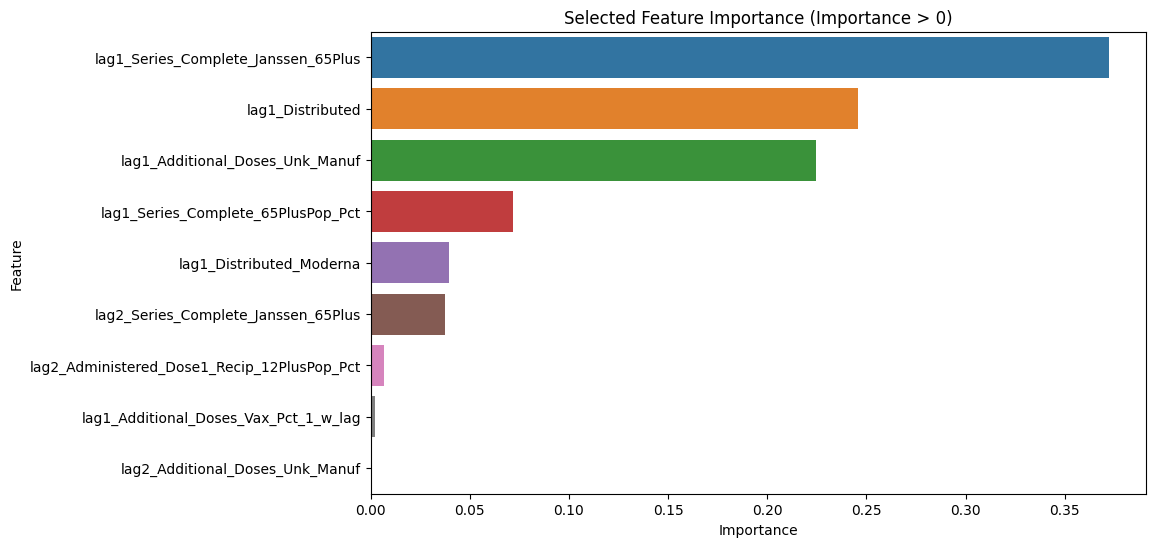

In [ ]:
# Filter feature importance DataFrame for values greater than 0
selected_features_df = feature_importance_df[feature_importance_df['Importance'] > 0]

# Print or display the selected features
print("Selected Features with Importance > 0:")
print(selected_features_df)

# Optionally, you can plot the selected feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=selected_features_df)
plt.title('Selected Feature Importance (Importance > 0)')
plt.show()

In evaluating the XGBoost models, the base model utilizing all variables exhibited a Training RMSE of 0.0007 and a Test RMSE of 0.0116. Upon selecting the features used in the base model, a subsequent grid search was performed to tune parameters on a model that exclusively incorporated the 27 preselected variables. The final model, fitted with the parameters derived from the grid search, yielded notable improvements:

**Best Parameters - {'subsample': 1.0, 'reg_lambda': 0.00032, 'reg_alpha': 0.00032, 'n_estimators': 150, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.05, 'eta': 0.2, 'colsample_bytree': 0.8.**

 The Training RMSE with the best model was 0.00031, and the Test RMSE was 0.00986. Although the graphs depicting actual values versus predicted values and residuals may not exhibit perfection, the achieved RMSE values suggest a commendable performance in predictive accuracy.

 Based on feature importance I was also able to idnetify the key variables used to predict teh Additional Booster Doses:
1.   **lag1_Series_Complete_Janssen_65Plus**
2.   **lag1_Distributed**

3. **lag1_Additional_Doses_Unk_Manuf**






### Ungrouped Data

Subsequently, I constructed a model using ungrouped data to facilitate performance comparison. The dataset remained scaled, and I introduced lag features of 1, 2, and 3 weeks to each column, akin to the previous approach. Following this, Spearman's correlation analysis was conducted to pinpoint strongly correlated variables. Notably, due to the weaker correlation between variables and the target in the ungrouped data, the correlation threshold was adjusted to 0.4. This modification resulted in a refined selection, limiting the chosen variables to only 14.

In [ ]:
df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Select only numerical columns
numerical_columns = df.select_dtypes(include=['number'])

# Apply Min-Max scaling only to numerical columns
scaler = MinMaxScaler(feature_range=(0, 1))
df[numerical_columns.columns] = scaler.fit_transform(numerical_columns)

data = df.sort_values(by ='Date',ascending=True)
data = data.drop('Additional_Doses_Vax_Pct_1_w_lag', axis =1)

In [ ]:
def process(df, lags=[1], categorical_columns=[]):
    ret = df[[pred_var]]

    for lag in lags:
        lagdf = df.shift(lag)

        # Exclude categorical columns from lag operation
        numerical_lagdf = lagdf.drop(categorical_columns, axis=1, errors='ignore')

        numerical_lagdf.columns = [f'lag{lag}_' + str(col) for col in numerical_lagdf.columns]
        ret = pd.concat([ret, numerical_lagdf], axis=1)

    return ret.fillna(0)

# Example usage
data = process(data, lags=[1, 2, 3], categorical_columns=['lag1_Location', 'lag1_day_of_week', 'lag1_season'])

# Split data into test and train

# # Check for duplicate columns
duplicates = data.columns[data.columns.duplicated()]

# # Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

In [ ]:
df = data.copy()
df = df.drop('Additional_Doses_Vax_Pct', axis = 1)
# Exclude 'date' column from correlation calculation
numeric_columns = df.select_dtypes(include=['float64']).columns
correlations = df[numeric_columns].apply(lambda x: spearmanr(x, data[pred_var]).correlation)

# Rank features based on absolute correlation values
ranked_features = correlations.abs().sort_values(ascending=False)

# Filter columns with correlation >= 0.3
selected_features = correlations[correlations.abs() >= 0.4].index.tolist()
#print("Selected Features:", selected_features)
selected_features_pred = selected_features + [pred_var]

Dealing with ungrouped data presented a challenge when it came to the test and train split. The presence of multiple rows with the same date prevented the conventional method of ordering the dataset by date and splitting it at the 80% mark. In response to this, I devised an alternative approach by determining the date at which the original data was split, which was identified as 2023-01-29. Subsequently, I split the data based on this specific date, ensuring a suitable division between the training and testing sets.

In [ ]:
#forecast_start_dt = date(2023,1,29)
split_date = pd.to_datetime('2023-01-29')
data_s = data[selected_features_pred]
# Split the data based on the date
train_data = data_s[data_s.index < split_date]
test_data = data_s[data_s.index >= split_date]

I first fit a base line model with default paramters on the preselected variables.

In [ ]:
# Set XGBoost parameters
params = {
        'objective': 'reg:squarederror',  # Regression task with mean squared error loss
        'eval_metric': 'rmse'  # Root Mean Squared Error as the evaluation metric
    }

train_rmse, test_rmse, feature_importance, y_test_pred = train_and_evaluate_xgboost(train_data, test_data, params)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 0.05864995455892582
Test RMSE: 0.14283917444433014


The baseline model's performance was quite decent with Training RMSE of 0.05 and Test RMSE of 0.14. However, it was a bit higher than for teh grouped data. In an effort to mitigate this issue, I conducted a Randomized Grid Search to identify optimal parameter values for the model. To ensure a fair comparison, I maintained consistency by employing the same param_grid as used for the grouped data, allowing for a comprehensive evaluation of the model's performance across both scenarios.

In [ ]:
# corse grid search
# tune hyperparams

X_train, y_train = train_data.drop(pred_var, axis=1), train_data[pred_var]
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Define the parameter grid to search
param_grid = {
    'max_depth': [2,3,5],
    'min_child_weight': [3, 5,6,7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'eta': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100,150,200,250],
    'learning_rate': [0.001, 0.01, 0.05],
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Create an XGBoost regressor
xg_reg = xgb.XGBRegressor(**params)

# Define mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = RandomizedSearchCV(
    estimator=xg_reg,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)


# Perform grid search to find the best hyperparameters
grid_result = grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding RMSE
print("Best Parameters: ", grid_result.best_params_)
print("Best RMSE: ", np.sqrt(-grid_result.best_score_))

# Get the best model from the grid search
best_model = grid_result.best_estimator_

# You can use this best_model for predictions on the test set
# Assuming you have your test_data DataFrame
X_test, y_test = test_data.drop(pred_var, axis=1), test_data[pred_var]
dtest = xgb.DMatrix(X_test, label=y_test)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
# Evaluate the best model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train RMSE with Best Model: {train_rmse}')
print(f'Test RMSE with Best Model: {test_rmse}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'subsample': 0.9, 'reg_lambda': 0.31622776601683794, 'reg_alpha': 0.00031622776601683794, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.05, 'eta': 0.1, 'colsample_bytree': 0.9}
Best RMSE:  0.13803120393250864
Train RMSE with Best Model: 0.13236740398766278
Test RMSE with Best Model: 0.12548554964333358


While the tuned model exhibited a slight improvement in Test Data performance, its Train Data performance was inferior, resulting in an overall performance that was not significantly better than the baseline model. In summary, both ungrouped models displayed notably poorer performance compared to the grouped model.

### Final Model

The XGBoost final model, tuned on grouped data, demonstrated exceptional performance on both test and train datasets. Its robust performance unveiled crucial insights into variables associated with the target variable.

## Keras LSTM

### Data Preparation

Keras LSTM is a recurrent neural network architecture designed for effective time series prediction. It processes sequential data by maintaining internal memory cells that store and update information over time. Through forget, input, and output gates, the LSTM controls the flow of information, allowing it to capture and remember temporal patterns in the input sequences. Specifically tailored for time series data, the LSTM learns from historical context during training, enabling it to make predictions for future time steps. Training involves adjusting the model's parameters to minimize the difference between predicted and actual values. With its ability to capture long-term dependencies, Keras LSTM is well suited for forecasting complex patterns in time series datasets.

I've once again processed the data by grouping and scaling, a crucial step for LSTM models. The normalization or scaling is imperative for LSTMs due to their heightened sensitivity to variations in data scale. This ensures a consistent and standardized representation of the data, a prerequisite for the LSTM to effectively discern and learn patterns within the sequential data.


Before training the model it is essential to frame the dataset as a supervised learning problem. In this case the supervised learnign problem is predicting the booster_vaccine rate at the current week (t) given the other variables at the prior time step. I used the series_to_supervised function to convert the time series data into a supervised learning format suitable for LSTM models. This involved creating lag features for both input and output variables. Lastly I had to reshape input data into a 3D matrix to fit LSTM model requirements.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  agg = concat(cols, axis=1)
  agg.columns = names
  if dropnan:
    agg.dropna(inplace=True)
  return agg

# load dataset
pred_var = 'Additional_Doses_Vax_Pct'
data = pd.read_csv('df_post_eda.csv')

data['Date'] = pd.to_datetime(data['Date'])
data = data.groupby('Date').mean()
values = data.values
# integer encode direction
encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.843137   0.000000   0.000000   0.000000   0.000000        1.0   
2   0.862745   0.035505   0.083761   0.034580   0.045848        0.0   
3   0.882353   0.072682   0.164997   0.077333   0.080529        0.0   
4   0.901961   0.102544   0.261788   0.091649   0.117759        0.0   
5   0.921569   0.110295   0.300936   0.096530   0.126515        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var60(t)  var61(t)  \
1   0.000000   0.000000   0.000000    0.000000  ...  0.000000  0.909091   
2   0.035776   0.035678   0.041371    0.048715  ...  0.012586  0.909091   
3   0.067730   0.066477   0.071860    0.080049  ...  0.029076  0.909091   
4   0.095375   0.093287   0.098441    0.107215  ...  0.038226  1.000000   
5   0.103134   0.100809   0.105900    0.114821  ...  0.051134  1.000000   

   var62(t)  var63(t)  var64(t)  var65(t)  var66(t)  var67(t)  var68(t)  \
1       0.0       1.0  0.863510  0.300000  0.86

<ipython-input-6-7fe91d21086e>:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby('Date').mean()


## Model Building

The key parameters for the Keras LSTM are:

1. **Input Size (`input_dim`):** The dimensionality of the input sequences. For example, if you're processing sequences of word embeddings with dimension 300, `input_dim` would be 300.

2. **Hidden Size (`hidden_dim`):** The number of LSTM units or cells in the hidden layer. This parameter determines the model's capacity to learn and remember patterns in the input data.

3. **Number of Layers (`num_layers`):** LSTMs can be stacked to form deep networks. This parameter defines how many LSTM layers are stacked on top of each other.

4. **Activation Functions:**
    - **Hyperbolic Tangent (`tanh`):** The activation function used inside the LSTM cells to regulate the flow of information.
    - **Sigmoid (`sigmoid`):** Used for the input, forget, and output gates to control the information flow.

5. **Cell State (`Ct`) and Hidden State (`ht`):** The LSTM maintains a cell state (`Ct`) and a hidden state (`ht`). The cell state acts as a long-term memory, while the hidden state contains the short-term memory.

6. **Forget Gate (`ft`), Input Gate (`it`), Output Gate (`ot`):** These gates control the flow of information through the cell state. The forget gate decides what information to discard from the cell state, the input gate updates the cell state with new information, and the output gate regulates the information passed to the hidden state.

7. **Dropout:** A regularization technique that randomly drops a fraction of connections during training to prevent overfitting.

8. **Bidirectionality (`bidirectional`):** An LSTM can process sequences in both forward and backward directions. Setting `bidirectional=True` doubles the number of hidden units and processes the input sequence from both directions.

These parameters collectively define the architecture and behavior of an LSTM model, allowing it to effectively capture dependencies in sequential data.

For my model I compiled it with MAE as the loss fucntion and the Adam optimizer. I trained the model fot 50 epochs with a bach size of 72.

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(data) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(64, 1, 137) (64,) (15, 1, 137) (15,)


Epoch 1/50
1/1 - 5s - loss: 0.8476 - val_loss: 0.8127 - 5s/epoch - 5s/step
Epoch 2/50
1/1 - 0s - loss: 0.6404 - val_loss: 0.5334 - 62ms/epoch - 62ms/step
Epoch 3/50
1/1 - 0s - loss: 0.4363 - val_loss: 0.2557 - 48ms/epoch - 48ms/step
Epoch 4/50
1/1 - 0s - loss: 0.2396 - val_loss: 0.0244 - 63ms/epoch - 63ms/step
Epoch 5/50
1/1 - 0s - loss: 0.0902 - val_loss: 0.2494 - 63ms/epoch - 63ms/step
Epoch 6/50
1/1 - 0s - loss: 0.1682 - val_loss: 0.3645 - 47ms/epoch - 47ms/step
Epoch 7/50
1/1 - 0s - loss: 0.2477 - val_loss: 0.3904 - 65ms/epoch - 65ms/step
Epoch 8/50
1/1 - 0s - loss: 0.2701 - val_loss: 0.3617 - 48ms/epoch - 48ms/step
Epoch 9/50
1/1 - 0s - loss: 0.2501 - val_loss: 0.2977 - 69ms/epoch - 69ms/step
Epoch 10/50
1/1 - 0s - loss: 0.2021 - val_loss: 0.2103 - 54ms/epoch - 54ms/step
Epoch 11/50
1/1 - 0s - loss: 0.1376 - val_loss: 0.1094 - 76ms/epoch - 76ms/step
Epoch 12/50
1/1 - 0s - loss: 0.0782 - val_loss: 0.0131 - 64ms/epoch - 64ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0553 - val_loss: 0.066

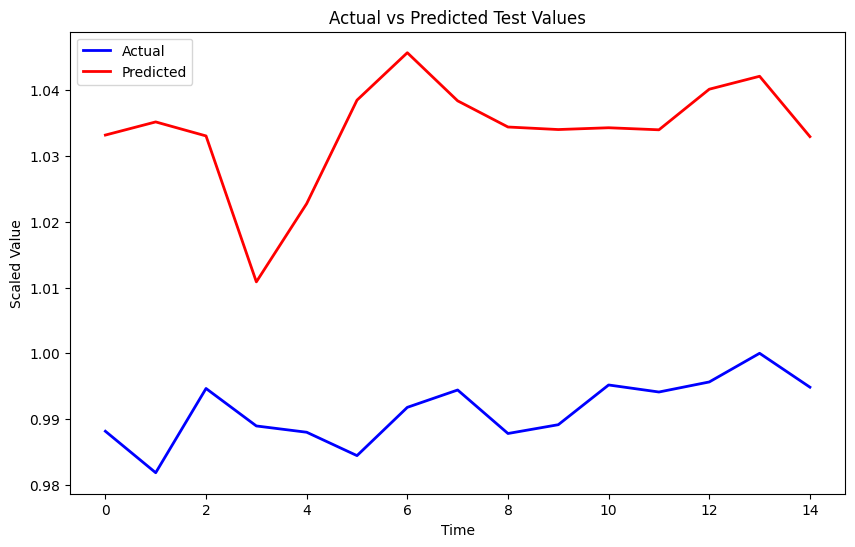

In [ ]:
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Make predictions on the test set
yhat = model.predict(test_X)

# Plot actual vs predicted values
pyplot.figure(figsize=(10, 6))
pyplot.plot(test_y, label='Actual', color='blue', linewidth=2)
pyplot.plot(yhat, label='Predicted', color='red', linewidth=2)
pyplot.title('Actual vs Predicted Test Values')
pyplot.xlabel('Time')
pyplot.ylabel('Scaled Value')  # Adjust ylabel as needed
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
#yhat = model.predict(test_X)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.013


In general, the LSTM model performs well. I had to manually adjust the model by experimenting with various parameter values because of challenges with TensorFlow on my laptop. These challenges restricted the import of certain modules. Despite these issues, the model's predicted values closely align with the actual values, and the Test RMSE of 0.013 is notably low.

# Results

## Model Performance Comparison

ARIMA (1,1,0):
The ARIMA model with parameters (1,1,0) displays remarkable precision, as evidenced by the very low Test RMSE of 0.000351. However, its applicability may be limited to linear trends and stationary data.

Auto_ARIMA (SARIMAX(0, 1, 2)(0, 0, 2, 12)):
Auto_ARIMA, utilizing a Seasonal AutoRegressive Integrated Moving Average with exogenous variables (SARIMAX) approach, produces a Test RMSE of 0.00117. It is adept at capturing seasonality and accommodating external factors, offering versatility in handling various time series patterns.

Prophet Univariate:
Prophet, in its univariate configuration with hyperparameters set as {'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.5, 'n_changepoints': 30}, yields satisfactory results. However, the Test RMSE of 0.024453 suggests potential challenges in accurately capturing the variability in the test set.

Prophet Multivariate:
The multivariate Prophet model, incorporating parameters {changepoint_prior_scale: 0.5, seasonality_prior_scale: 0.01, holidays_prior_scale: 0.01, seasonality_mode: 'additive'}, outperforms its univariate counterpart with a lower Training RMSE of 3.1828e-07. Nevertheless, the Testing RMSE of 0.04666 indicates some difficulty in generalizing to unseen data.

XGBoost:
The XGBoost model, configured with {'subsample': 1.0, 'reg_lambda': 0.00031622776601683794, 'reg_alpha': 0.00031622776601683794, 'n_estimators': 150, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.05, 'eta': 0.2, 'colsample_bytree': 0.8}, excels in predictive accuracy with a low Test RMSE of 0.009859. Its ability to handle complex relationships and feature importance contributes to its strong performance.

LSTM Model:
The LSTM model, though exhibiting a slightly higher Test RMSE of 0.013, showcases competitive predictive capabilities. Its recurrent neural network architecture enables the capture of intricate temporal dependencies in the data, but it requires careful parameter tuning and may be computationally demanding.

## Analysis of Results

The ARIMA model, with a remarkably low Test RMSE of 0.000351, emerges as the best-performing model in this analysis. Several factors contribute to its success in this particular context. Firstly, given the relatively small size of the dataset, the simplicity of the ARIMA model becomes advantageous. The other models, being more complex, run the risk of overfitting to the limited data available. The ARIMA model's ability to capture patterns based solely on the past history of the variable makes it less prone to overfitting.

The superiority of the ARIMA model, with its notably low Test RMSE of 0.000351, is further underscored by its ability to excel in capturing subtle changes in trends. Specifically, the utilization of a one-day rolling forecast strategy enhances the model's sensitivity to small variations in the data that might be overlooked by other models. The one-day rolling forecast approach allows the model to adapt swiftly to short-term fluctuations and adjustments in the vaccination rates.

This adaptability becomes crucial in this scenario fue to the dataset being relatively small, and the trends may exhibit subtle, day-to-day shifts. The simplicity of the ARIMA model, coupled with the one-day rolling forecast strategy, facilitates the detection and incorporation of these nuanced changes, contributing to its effectiveness in forecasting vaccine rates. While more complex models might overlook or smooth out these small variations, ARIMA's nimble response to one-day changes proves advantageous in capturing the intricacies of the time series data, further solidifying its status as the best-performing model for this forcasting.

Moreover, the independence of the ARIMA model from additional predictor variables aligns well with the nature of the project. The primary objective of this project  is to predict future vaccine rates, where the absence of other variables (such as vaccine distribution numbers) is expected. In this scenario, ARIMA's reliance solely on the time series history of the variable proves to be a significant advantage. While other models may leverage additional features for predictive accuracy, the simplicity and independence of ARIMA make it particularly beneficial for this specific forecasting task.

Nevertheless, it is crucial to acknowledge the significance of the XGBoost model within the context of vaccine rate prediction. This model uniquely offers valuable insights through its ability to provide feature importance, shedding light on which variables warrant closer examination when trying to predict vaccine rates. By unraveling the importance of each predictor, XGBoost enables a nuanced understanding of the factors influencing vaccination rates. This not only facilitates accurate short-term predictions but also empowers government officials and healthcare workers with actionable intelligence. The model's capability to highlight variables with higher impact allows for more targeted suggestions and informed decision-making, offering a valuable path of action to enhance vaccination strategies and outcomes.

# Discussion

Although some of the models demonstrated relatively good performance, the overall average performance on the test data proved insufficient. Many of the models exhibited pronounced overfitting issues, and, based on residuals, failed to capture patterns in the data. The primary reason for these challenges stems from the initial selection of data, which is not well-suited for time series forecasting. This was an oversight on my part, as I had limited experience with time series prediction and was unfamiliar with crucial considerations for ensuring the data's compatibility with models. Additionally, the switch to weekly data aggregation midway through the dataset required resampling, resulting in only 80 weeks of data, a relatively small amount for both training and testing. Another contributing factor to these issues was the selection of a cumulative variable as the target. The chosen variable represented the total percentage of the population that received the booster, ensuring that the data values could only increase and lacked common time series features like fluctuations and variations.

Despite these challenges, this project significantly enhanced my confidence in programming and data science skills. Working on a project of my own choice from start to finish provided valuable insights and lessons. The experience was crucial in solidifying the knowledge gained during the Stat 303 sequence. Not only did I acquire knowledge about five time series prediction models that were new to me, but I also honed my independent study skills. Throughout the project, I dedicated considerable effort to understanding new data science concepts independently.

The collaborative nature of the project was particularly enjoyable. Working with my group until the midterm project report fostered a collaborative learning environment and allowed me to better know my peers. I regret not having the opportunity to collaborate more with my teammates on the model development aspect of the project, as I highly valued their insights and thoughts. Without their contributions, I believe I would not have gained as much from this project.

# Conclusion & Next Steps
The ARIMA model serves as a valuable tool for delving into COVID vaccine trends at a national level. Through this research, the primary discovery underscores the ARIMA model's exceptional efficacy in predicting future vaccine rates. Its autonomy from external regressors positions it as a reliable source of information, offering nuanced insights into vaccine rate trends. Additionally, the XGBoost model's analysis highlights lag1_Series_Complete_Janssen_65Plus as the variable of utmost importance, suggesting a significant correlation between vaccine rates and the demographic of individuals aged 65 and above. This discovery serves as a foundation for targeted investigations into vaccination rates for this specific age group. Moving forward, the logical progression for this project involves refining the ARIMA model to focus on specific locations or demographics. By honing in on a particular state or age group, the model can provide a more granular understanding of vaccine rate trends. Such insights are crucial for informed healthcare and pharmaceutical decision-making, ultimately contributing to more effective public health strategies.

In reflection, I consider the collaborative learning process to be the cornerstone of this project. The shared learning experience not only deepened my understanding of the subject matter but also propelled my skills in data science and model development to new heights. Engaging with others in the learning journey proved to be a catalyst for exploration and innovation. The collective pursuit of knowledge, with peers learning alongside, not only alleviated the inherent challenges but also served as a constant source of motivation. The camaraderie in tackling new concepts and methodologies made the learning process more approachable, fostering an environment where everyone's contributions contributed to the collective advancement of skills and insights.


# Appendices

In [ ]:
## Prophet Finding Ideal CV params

from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import ParameterGrid

param_grid = {
    'initial': list(range(7, 175, 7)),
    'period': [7, 14, 21] ,
    'horizon': [7, 14, 21]
}

all_params = list(ParameterGrid(param_grid))

best_rmse = float('inf')
best_params = None

for params in all_params:
    model = Prophet().fit(train_set)
    horizon = f'{params["horizon"]} days'
    initial = f'{params["initial"]} days'
    period = f'{params["period"]} days'

    df_cv = cross_validation(model, horizon=horizon, initial=initial, period=period)

    metrics = performance_metrics(df_cv)
    rmse = metrics['rmse'].mean()

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

In [ ]:
# tunning for Prophet Multivariate
from itertools import product
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 0.5],
    'holidays_prior_scale': [0.01],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params)
    for col in train_data.columns:
        if col not in ['ds', 'y']:
            model.add_regressor(col)
    model.fit(train_data)
    df_cv = cross_validation(model, parallel="processes", initial='133 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# References

Abulkhair, A. (2023, June 13). Data Imputation Demystified | Time Series Data | by Ahmed Abulkhair. Medium. Retrieved October 25, 2023, from https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7

Hahn, S. (n.d.). COVID-19 Vaccines. FDA. Retrieved October 25, 2023, from https://www.fda.gov/emergency-preparedness-and-response/coronavirus-disease-2019-covid-19/covid-19-vaccines

Kates, J., Tolbert, J., & Rouw, A. (2021, December 8). An Update on Vaccine Roll-Out for 5-11 Year-olds in the U.S. KFF. Retrieved October 25, 2023, from https://www.kff.org/coronavirus-covid-19/issue-brief/an-update-on-vaccine-roll-out-for-5-11-year-olds-in-the-u-s/

Montel, M. (2017). holidays · PyPI. PyPI. Retrieved October 25, 2023, from https://pypi.org/project/holidays/
